Debemos preparar datos, probar varios modelos, preseleccionar los mejores, ajustar sus hiperparámetros usando GridSearchCV y automatizar todo lo posible

# Dataset

https://www.kaggle.com/datos_estudiantessets/kundanbedmutha/exam-score-prediction-dataset?resource=download

# Imports
Importamos todos lso elementos que usaremos a lo largo del notebook. También, definimos la semilla utilizada para que todas las ejecuciones tengan el mismo resultado

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import io

from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Definimos la semilla
np.random.seed(42)

# Carga del dataset

In [ ]:
datos_estudiantes = pd.read_csv("Datasets/Exam_Score_Prediction.csv", sep=',', index_col="student_id")
datos_estudiantes.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Exam_Score_Prediction.csv'

# Selección y extracción de atributos

Vamos a comenzar reduciendo el número de atributos de nuestra dataset, lo cual es muy importante para evitar la maldición de la dimensionalidad (curse of dimensionality). En caso contrario, los efetos serían:

- Cuando aumenta la dimensionalidad, el volumen del espacio aumenta exponencialmente haciendo que los datos disponibles se vuelvan dispersos. 
- Esta dispersión impide que los algoritmos de aprendizaje puedan construir buenos modelos.

La estrategias que utilizaremos para luchar contra la maldición de la dimensionalidad sonla selección y extracción de atributos. 

En primer lugar, construiremos nuevos atributos a partir de los originales.Posteriormente, seleccionaremos un buen conjunto de atributos. 

In [ ]:
#Creamos un atributo para saber si han aprobado
datos_estudiantes['passed']=datos_estudiantes['exam_score']>=50.00

#Creamos un atributo para saber si la calificación obtenida es failed, passed, good, merit o excellent
def calculo_calificacion_estudiante(estudiante):
    if (estudiante.loc['exam_score']<50.00):
        return 'failed'
    elif (estudiante.loc['exam_score']<60.00):
        return 'passed'
    elif (estudiante.loc['exam_score']<70.00):
        return 'good'
    elif (estudiante.loc['exam_score']<90.00):
        return 'merit'
    else:
        return 'Excellent'
    
datos_estudiantes['mark']=datos_estudiantes.apply(lambda datos_estudiantes:calculo_calificacion_estudiante(datos_estudiantes), axis=1)

datos_estudiantes

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9,True,passed
2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8,True,passed
3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3,True,Excellent
4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7,False,failed
5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7,False,failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,18,other,bba,6.50,71.3,yes,5.0,good,self-study,low,easy,86.5,True,merit
19998,18,male,b.com,3.71,41.6,no,5.9,average,coaching,medium,moderate,60.9,True,good
19999,19,other,diploma,7.88,68.2,yes,4.6,poor,group study,low,easy,64.5,True,good


A continuación, para poder utilizar los algoritmos, preprocesamos el dataframe datos_estudiantes para tener exclusivamente datos numéricos

In [ ]:
def preprocesamiento_calificaciones(datos_estudiantes):
    if datos_estudiantes['mark']=='failed':
        m=0
    elif datos_estudiantes['mark']=='passed':
        m=1
    elif datos_estudiantes['mark']=='good':
        m=2
    elif datos_estudiantes['mark']=='merit':
        m=3
    else:
        m=4
    datos_estudiantes['mark']=m
    return datos_estudiantes
    

datos_estudiantes = datos_estudiantes.apply(preprocesamiento_calificaciones, axis=1)
datos_estudiantes

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9,True,1
2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8,True,1
3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3,True,4
4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7,False,0
5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,18,other,bba,6.50,71.3,yes,5.0,good,self-study,low,easy,86.5,True,3
19998,18,male,b.com,3.71,41.6,no,5.9,average,coaching,medium,moderate,60.9,True,2
19999,19,other,diploma,7.88,68.2,yes,4.6,poor,group study,low,easy,64.5,True,2


Para evitar realizar este trabajo manualmente, utilizaremos la función LabelEncoder() de scikitLearn, que nos ayudará a transformar todos los valores de un atributo a números

Para cada atributo, seguimos el siguiente proceso:
1. Generamos el encoder.
2. Ajustamos el encoder al atributo.
3. Transformamos los valores a numérico.
4. Imprimimos en consola un mensaje para saber qué atributo se está transformando
5. 

In [ ]:
gender_encoder = LabelEncoder()
gender_encoder.fit(datos_estudiantes['gender'])
datos_estudiantes['gender'] = gender_encoder.transform(datos_estudiantes['gender'])
print("Codificamos el género")
print(list(gender_encoder.classes_))
print(gender_encoder.transform(gender_encoder.classes_))

course_encoder = LabelEncoder()
course_encoder.fit(datos_estudiantes['course'])
datos_estudiantes['course'] = course_encoder.transform(datos_estudiantes['course'])
print("\nCourse codification")
print(list(course_encoder.classes_))
print(course_encoder.transform(course_encoder.classes_))

internet_access_encoder = LabelEncoder()
internet_access_encoder.fit(datos_estudiantes['internet_access'])
datos_estudiantes['internet_access'] = internet_access_encoder.transform(datos_estudiantes['internet_access'])
print("\nCourse codification")
print(list(internet_access_encoder.classes_))
print(internet_access_encoder.transform(internet_access_encoder.classes_))

sleep_quality_encoder = LabelEncoder()
sleep_quality_encoder.fit(datos_estudiantes['sleep_quality'])
datos_estudiantes['sleep_quality'] = sleep_quality_encoder.transform(datos_estudiantes['sleep_quality'])
print("\nSleep Quality codification")
print(list(sleep_quality_encoder.classes_))
print(sleep_quality_encoder.transform(sleep_quality_encoder.classes_))

study_method_encoder = LabelEncoder()
study_method_encoder.fit(datos_estudiantes['study_method'])
datos_estudiantes['study_method'] = study_method_encoder.transform(datos_estudiantes['study_method'])
print("\nStudy Method codification")
print(list(study_method_encoder.classes_))
print(study_method_encoder.transform(study_method_encoder.classes_))

facility_rating_encoder = LabelEncoder()
facility_rating_encoder.fit(datos_estudiantes['facility_rating'])
datos_estudiantes['facility_rating'] = facility_rating_encoder.transform(datos_estudiantes['facility_rating'])
print("\nFacility Rating codification")
print(list(facility_rating_encoder.classes_))
print(facility_rating_encoder.transform(facility_rating_encoder.classes_))

exam_difficulty_encoder = LabelEncoder()
exam_difficulty_encoder.fit(datos_estudiantes['exam_difficulty'])
datos_estudiantes['exam_difficulty'] = exam_difficulty_encoder.transform(datos_estudiantes['exam_difficulty'])
print("\nExam Difficulty codification")
print(list(exam_difficulty_encoder.classes_))
print(exam_difficulty_encoder.transform(exam_difficulty_encoder.classes_))

passed_encoder = LabelEncoder()
passed_encoder.fit(datos_estudiantes['passed'])
datos_estudiantes['passed'] = passed_encoder.transform(datos_estudiantes['passed'])
print("\nExam Difficulty codification")
print(list(passed_encoder.classes_))
print(passed_encoder.transform(passed_encoder.classes_))

Codificamos el género
['female', 'male', 'other']
[0 1 2]

Course codification
['b.com', 'b.sc', 'b.tech', 'ba', 'bba', 'bca', 'diploma']
[0 1 2 3 4 5 6]

Course codification
['no', 'yes']
[0 1]

Sleep Quality codification
['average', 'good', 'poor']
[0 1 2]

Study Method codification
['coaching', 'group study', 'mixed', 'online videos', 'self-study']
[0 1 2 3 4]

Facility Rating codification
['high', 'low', 'medium']
[0 1 2]

Exam Difficulty codification
['easy', 'hard', 'moderate']
[0 1 2]

Exam Difficulty codification
[False, True]
[0 1]


In [8]:
datos_estudiantes.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,17,1,6,2.78,92.9,1,7.4,2,0,1,1,58.9,1,1
2,23,2,5,3.37,64.8,1,4.6,0,3,2,2,54.8,1,1
3,22,1,1,7.88,76.8,1,8.5,2,0,0,2,90.3,1,4
4,20,2,6,0.67,48.4,1,5.8,0,3,1,2,29.7,0,0
5,20,0,6,0.89,71.6,1,9.8,2,0,1,2,43.7,0,0


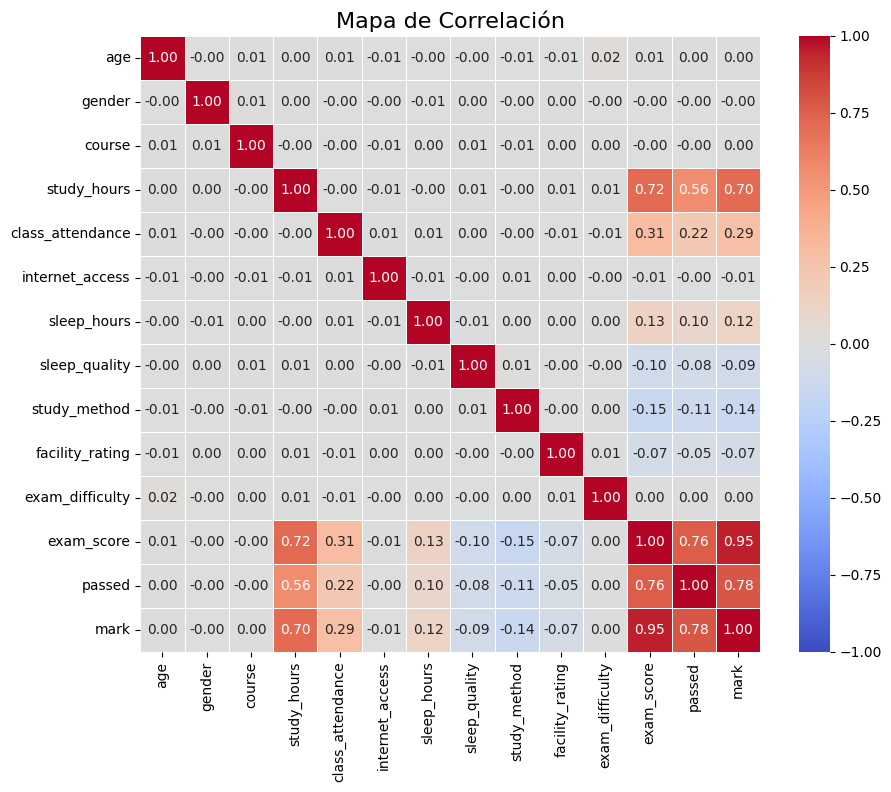

In [9]:
matriz_correlacion = datos_estudiantes.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Mapa de Correlación', fontsize=16)
plt.show()

# Clasificación

Las tareas de clasificación pertenecen al aprendizaje supervisado y consisten en predecir la clase a la que pertenece un individuo.

El conjunto de datos seleccionado contiene información sobre datos académicos, hábitos y la rutina de 20.000 estudiantes de entre 17 y 24 años. Esta información nos permitirá entender cómo diferentes aspectos en la vida de un estudiante afectan a su rendimiento académico.

En concreto, los 13 atributos son los siguientes:

* Student_id: identificador único del estudiante (1 - 20.000)
* Age: edad (17 - 24 años)
* Gender: género (male, female, other)
* Course: curso de estudio.
  * Diploma: Formación Profesional
  * Bachelor of Computer Aplications (BCA): grado de aplicaciones de computación, aplicado a la informática y desarrollo de software
  * Bachelor of Science (B.Sc): grado de ciencias (sin especificar la especialidad)
  * Bachelor of Technology (B.Tech): ingeniería
  * Bachelor of Business Administration (BBA): grado en administración de empresas
  * Bachelor of Arts: grado en artes o humanidades.
  * Bachelor of Commerce (B.Com): grado en comercio, contabilidad o finanzas
* Study_hours: horas de estudio (0.00 - 7.91)
* Class_attendance: porcentaje de asistencia a clases (40.6 - 99.4)
* Internet_access: acceso a internet (true/false)
* Sleep_hours: Horas de sueño diarias (4.1 - 9.9)
* Sleep_quality: Calidad del sueño (poor, average, good)
* Study_method: método de estudio (self-study, online videos, coaching, group study, mixed)
* Facility_rating: valoración del lugar de estudio (low, medium, high)
* Exam_difficulty: dificultad del examen (easy, moderate, high)
* Exam_score: puntuación en el examen (0.00 - 100.00)
* Nueva columna: calificación --> failed, passed, good, merit, excellent

Nuestro objetivo es que, gracias a estos atributos que comprenden un amplio espectro de influencias observadas comúnmente en ambientes académicos, podamos entender con facilidad qué aspectos son más importantes en el rendimiento académico.

En concreto, se van a responder las siguientes preguntas:

* ¿Qué perfiles existen?
* ¿Qué modelo ofrece una mayor precisión para la predicción de exam_difficulty, facility_rating, study_method, sleep_quality, internet_access, course o gender?
* Se observa algo interesante entre sleep_quality y sleep_hours
* Qué atributos tienen más importancia y cómo el rendimiento al no usar exam_difficulty para evitar depender de la dificultad del examen
* Qué importancia tiene asistencia frente a horas de estudio para clasificar "calificación"
* ¿Qué comportamiento aparece al introducir variables derivadas como 'ratio de estudio - sueño' o 'índice de hábito'?
* Qué reglas extrae un árbol
* ¿Se mantiene el rendimiento al excluir algún curso del entrenamiento y test?
* ¿Cómo de robusto es el modelo a valores extremos o inconsistentes (outliers)?
* ¿Qué sucede si faltan datos en sleep_quality o internet_Access y se imputa?
* ¿Se cumple una igualdad entre subgrupos para la clase clasificación?
* Qué impacto tiene eliminar el género sobre el rendimiento global
* ¿Qué patrones caracterizan a los falsos positivos y falsos negativos?
* ¿Se concentran los falsos positivo/negativo en estudiantes con calificaciones excelentes?
* Cómo queda la matriz de confusión con las calificaciones?
* ¿Hay alguna métrica más informativa que el accuracy?
  
Hemos dado:
* Clasificación binaria
* Validación cruzada
* curva precisión/cobertura
* análisis ROC y AUC
* clasificación multiclase
* Análisis de errores. 
* Clasificación multietiqueta
* Clasificadores en cadena. Entrenar un clasificador por etiqueta y componer secuencialmente los clasificadores
* KNN
* Kmeans



# Redes Neuronales

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().set_output(transform="pandas")
datos_estudiantes_scaled = scaler.fit_transform(datos_estudiantes)
datos_estudiantes_scaled.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,passed,mark
student_id,,,,,,,,,,,,,,
1,0.000000,0.5,1.000000,0.344828,0.889456,1.0,0.568966,1.0,0.00,0.5,0.5,0.488812,1.0,0.25
2,0.857143,1.0,0.833333,0.420179,0.411565,1.0,0.086207,0.0,0.75,1.0,1.0,0.437818,1.0,0.25
3,0.714286,0.5,0.166667,0.996169,0.615646,1.0,0.758621,1.0,0.00,0.0,1.0,0.879355,1.0,1.00
4,0.428571,1.0,1.000000,0.075351,0.132653,1.0,0.293103,0.0,0.75,0.5,1.0,0.125633,0.0,0.00
5,0.428571,0.0,1.000000,0.103448,0.527211,1.0,0.982759,1.0,0.00,0.5,1.0,0.299760,0.0,0.00


## Regresion

In [11]:
from sklearn.model_selection import train_test_split

X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)
y = datos_estudiantes_scaled['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
import tensorflow as tf

nivel_oculto1 = tf.keras.layers.Dense(30, activation="relu")
nivel_oculto2 = tf.keras.layers.Dense(30, activation="relu")
nivel_union = tf.keras.layers.Concatenate()
nivel_salida = tf.keras.layers.Dense(1)

entrada = tf.keras.layers.Input(shape=X_train.shape[1:])
oculto1 = nivel_oculto1(entrada)
oculto2 = nivel_oculto2(oculto1)
salida = nivel_salida(oculto2)

modelo1 = tf.keras.Model(inputs=[entrada], outputs=[salida])

In [13]:
optimizador = tf.keras.optimizers.Adam(learning_rate=1e-3) #learning_rate=1e-3
modelo1.compile(optimizer=optimizador, loss="mse",  metrics=["RootMeanSquaredError"])

In [14]:
n_iter = 50
history1 = modelo1.fit(X_train, y_train, epochs=n_iter,
                    validation_data=(X_test, y_test))

Epoch 1/50


500/500 [==============================] - 3s 3ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1368
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0183 - root_mean_squared_error: 0.1353 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1366
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1309
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0165 - root_mean_squared_error: 0.1286 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1275
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0161 - root_mean_squared_error: 0.1270 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1270
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262 - val_loss: 0.0158 - va

In [15]:
print(history1.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])
[0.16901767253875732, 0.13531692326068878, 0.13165968656539917, 0.12856425344944, 0.1269955188035965, 0.12615160644054413, 0.1250186711549759, 0.1250886470079422, 0.12515904009342194, 0.12417285889387131, 0.1242440864443779, 0.1238151416182518, 0.12414699047803879, 0.12390556186437607, 0.12400129437446594, 0.12318171560764313, 0.12327563017606735, 0.12342750281095505, 0.12337759137153625, 0.12319539487361908, 0.12314359098672867, 0.1233527660369873, 0.12324449419975281, 0.12296401709318161, 0.1228843405842781, 0.12294761091470718, 0.12280016392469406, 0.12259549647569656, 0.1225903332233429, 0.12257080525159836, 0.12285193800926208, 0.12222450971603394, 0.12236791104078293, 0.12231393903493881, 0.12247783690690994, 0.12209416925907135, 0.12199397385120392, 0.12225836515426636, 0.12206855416297913, 0.12202282249927521, 0.12181741744279861, 0.1218172162771225, 0.12173936516046524, 0.1216365769505500

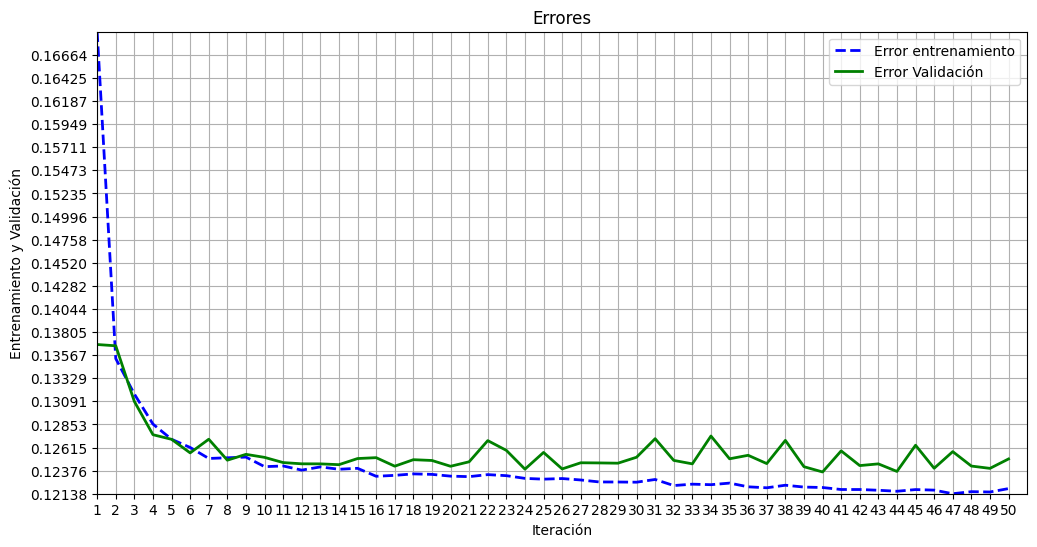

In [16]:
import numpy as np
errores_entrenamiento = history1.history['root_mean_squared_error']
errores_validacion = history1.history['val_root_mean_squared_error']
print(history1.history.keys())
print(errores_entrenamiento)
print(errores_validacion)

min_errores_entrenamiento = np.min(errores_entrenamiento)
min_errores_validacion = np.min(errores_validacion)
min = np.min([min_errores_entrenamiento,min_errores_validacion])

max_errores_entrenamiento = np.max(errores_entrenamiento)
max_errores_validacion = np.max(errores_validacion)
max = np.max([max_errores_entrenamiento,max_errores_validacion])



import matplotlib.pyplot as plt


iteraciones = np.arange(1, n_iter+1, 1)

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.grid(True)
ax.axis((1, n_iter+1, min, max))
ax.set_xticks(iteraciones)
ax.set_yticks(np.arange(min, max, (max-min)/20))

ax.plot(iteraciones, errores_entrenamiento, "b--", label="Entrenamiento", linewidth=2)
ax.plot(iteraciones, errores_validacion, "g-", label="Validación", linewidth=2)

ax.legend(["Error entrenamiento", "Error Validación"])

plt.title('Errores')
plt.xlabel('Iteración')
plt.ylabel('Entrenamiento y Validación')
plt.show()

## Clasificacion

In [26]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


# y_raw = datos_estudiantes['mark']   # NO scaled
# si mark está como texto: failed/passed/...
# usa LabelEncoder (esto da 0..4)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(datos_estudiantes['mark'])

# split estratificado
from sklearn.model_selection import train_test_split
X = datos_estudiantes_scaled.drop(['exam_score','passed','mark'], axis=1)  # X sí escalado
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

#Se le da un peso diferente a las clases. Así, si una clase tiene menos ejemplos, se le da más peso para evitar el desbalance. A una clase con más ejemplos, se le da un menor peso.
class_weights_arr = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("class_weights:", class_weights)


class_weights: {0: 0.7401533174729051, 1: 1.1272141706924315, 2: 1.0443864229765014, 3: 0.71483278018892, 4: 2.4669603524229076}


Definimos funciones para compilar el modelo, entrenarlo y evaluarlo, y mostrar el error graficamente

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt

def compila_modelo(modelo, lr=1e-3):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    modelo.compile(
        optimizer=opt,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ]
    )
    return modelo

def entrena_y_evalua(modelo, X_train, y_train, X_val, y_val, X_test, y_test,
                     epochs=80, batch_size=256, class_weights=None, callbacks=None, verbose=0):
    history = modelo.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks or [],
        verbose=verbose
    )

    # Evaluación final en test
    test_loss, test_acc = modelo.evaluate(X_test, y_test, verbose=0)

    # Reporte (macro-F1, precision/recall por clase, etc.)
    probs = modelo.predict(X_test, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    print("\nTest accuracy:", test_acc)
    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_], digits=4))
    print("Confusion matrix (test):\n", confusion_matrix(y_test, y_pred))

    return history, test_acc

def plot_history(history, titulo="Entrenamiento"):
    h = history.history
    epochs = np.arange(1, len(h["loss"]) + 1)

    # Loss
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h["loss"], "--", linewidth=2, label="loss train")
    plt.plot(epochs, h["val_loss"], "-", linewidth=2, label="loss val")
    plt.title(titulo + " | Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h["accuracy"], "--", linewidth=2, label="acc train")
    plt.plot(epochs, h["val_accuracy"], "-", linewidth=2, label="acc val")
    plt.title(titulo + " | Accuracy")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


Primer modelo: 
- 5 neuronas de salida
- Softmax como función de salida
- Entropía cruzada como función de pérdida
- Métrica accuracy

Epoch 1/80
55/55 [==============================] - 1s 7ms/step - loss: 1.5470 - accuracy: 0.3274 - val_loss: 1.4646 - val_accuracy: 0.4157
Epoch 2/80
55/55 [==============================] - 0s 3ms/step - loss: 1.3848 - accuracy: 0.4541 - val_loss: 1.2965 - val_accuracy: 0.4737
Epoch 3/80
55/55 [==============================] - 0s 3ms/step - loss: 1.2200 - accuracy: 0.4944 - val_loss: 1.1808 - val_accuracy: 0.4927
Epoch 4/80
55/55 [==============================] - 0s 3ms/step - loss: 1.1381 - accuracy: 0.5101 - val_loss: 1.1243 - val_accuracy: 0.5010
Epoch 5/80
55/55 [==============================] - 0s 3ms/step - loss: 1.1043 - accuracy: 0.5134 - val_loss: 1.1056 - val_accuracy: 0.5087
Epoch 6/80
55/55 [==============================] - 0s 3ms/step - loss: 1.0873 - accuracy: 0.5171 - val_loss: 1.0877 - val_accuracy: 0.5157
Epoch 7/80
55/55 [==============================] - 0s 3ms/step - loss: 1.0757 - accuracy: 0.5269 - val_loss: 1.0794 - val_accuracy: 0.5177
Epoch 8/80
55/55 [==

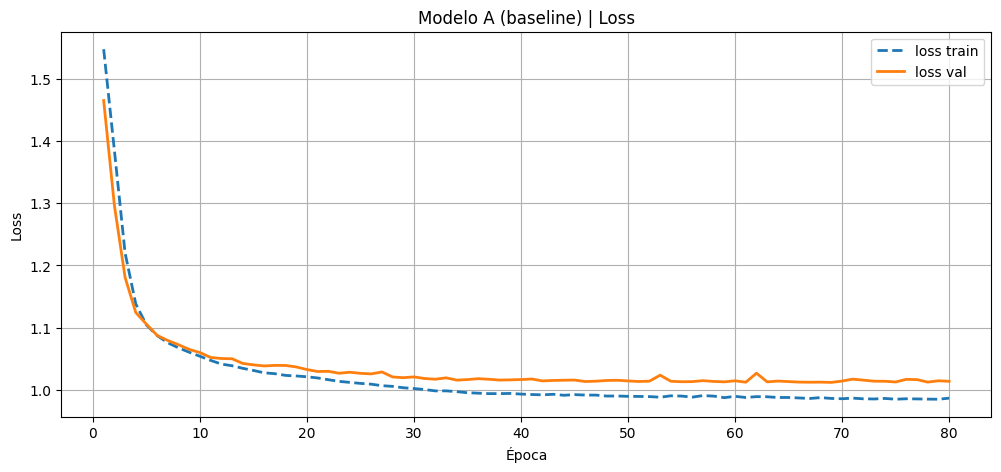

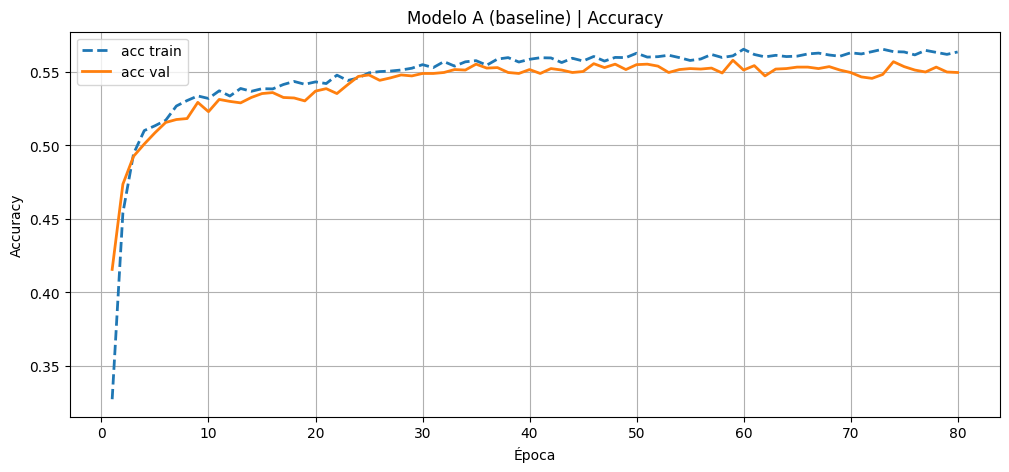

In [30]:
def build_model_A(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation="relu")(entrada)
    x = tf.keras.layers.Dense(30, activation="relu")(x)
    salida = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)
num_classes = 5
modeloA = build_model_A(X_train.shape[1], num_classes)
modeloA = compila_modelo(modeloA, lr=1e-3)

histA, accA = entrena_y_evalua(
    modeloA, X_train, y_train, X_val, y_val, X_test, y_test,
    epochs=80, batch_size=256, class_weights=None, verbose=1
)
plot_history(histA, "Modelo A (baseline)")


In [31]:
from sklearn.model_selection import train_test_split

X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)
y = datos_estudiantes_scaled['mark']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Epoch 1/50
500/500 [==============================] - 2s 2ms/step - loss: 0.0517 - root_mean_squared_error: 0.2274 - val_loss: 0.0433 - val_root_mean_squared_error: 0.2080
Epoch 2/50
500/500 [==============================] - 1s 1ms/step - loss: 0.0408 - root_mean_squared_error: 0.2020 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2002
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0391 - root_mean_squared_error: 0.1977 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1968
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1960
Epoch 5/50
500/500 [==============================] - 1s 1ms/step - loss: 0.0373 - root_mean_squared_error: 0.1930 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1935
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0369 - root_mean_squared_error: 0.1922 - val_loss: 0.0374 - val_

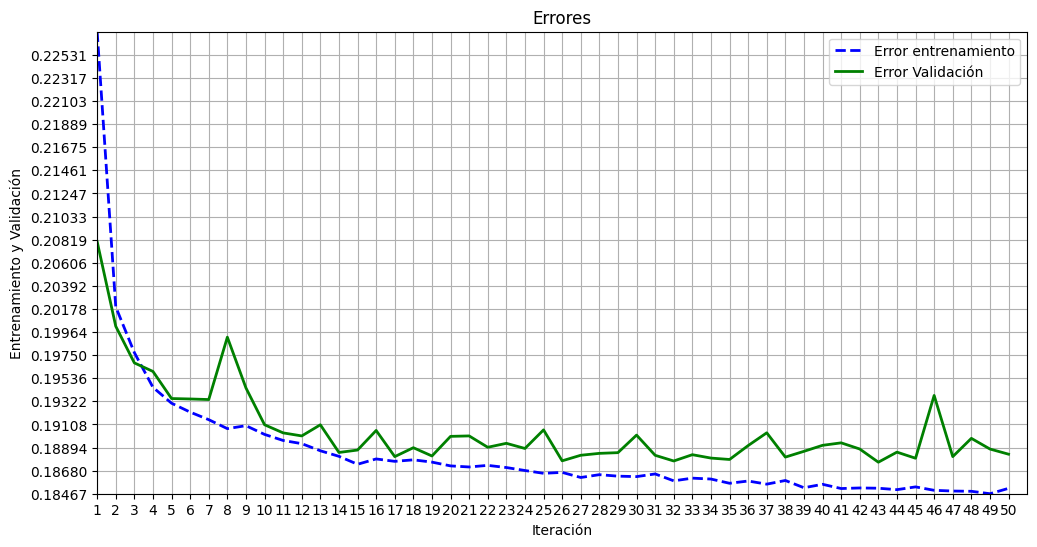

In [34]:
import tensorflow as tf


nivel_oculto1 = tf.keras.layers.Dense(30, activation="relu")
nivel_oculto2 = tf.keras.layers.Dense(30, activation="relu")
nivel_union = tf.keras.layers.Concatenate()
nivel_salida = tf.keras.layers.Dense(1)

entrada = tf.keras.layers.Input(shape=X_train.shape[1:])
oculto1 = nivel_oculto1(entrada)
oculto2 = nivel_oculto2(oculto1)
salida = nivel_salida(oculto2)

modelo1 = tf.keras.Model(inputs=[entrada], outputs=[salida])
optimizador = tf.keras.optimizers.Adam(learning_rate=1e-3)  #learning_rate=1e-3
modelo1.compile(optimizer=optimizador, loss="mse", metrics=["RootMeanSquaredError"])
n_iter = 50
history1 = modelo1.fit(X_train, y_train, epochs=n_iter,
                       validation_data=(X_test, y_test))
import numpy as np


errores_entrenamiento = history1.history['root_mean_squared_error']
errores_validacion = history1.history['val_root_mean_squared_error']
print(history1.history.keys())
print(errores_entrenamiento)
print(errores_validacion)

min_errores_entrenamiento = np.min(errores_entrenamiento)
min_errores_validacion = np.min(errores_validacion)
min = np.min([min_errores_entrenamiento, min_errores_validacion])

max_errores_entrenamiento = np.max(errores_entrenamiento)
max_errores_validacion = np.max(errores_validacion)
max = np.max([max_errores_entrenamiento, max_errores_validacion])

import matplotlib.pyplot as plt


iteraciones = np.arange(1, n_iter + 1, 1)

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.grid(True)
ax.axis((1, n_iter + 1, min, max))
ax.set_xticks(iteraciones)
ax.set_yticks(np.arange(min, max, (max - min) / 20))

ax.plot(iteraciones, errores_entrenamiento, "b--", label="Entrenamiento", linewidth=2)
ax.plot(iteraciones, errores_validacion, "g-", label="Validación", linewidth=2)

ax.legend(["Error entrenamiento", "Error Validación"])

plt.title('Errores')
plt.xlabel('Iteración')
plt.ylabel('Entrenamiento y Validación')
plt.show()

In [33]:
print("Claves:", history1.history.keys())

Claves: dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


# AQUÍ EMPIEZA LA PARTE DE PABLO

In [ ]:
#Comenzamos eliminando 
X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)
y_raw = datos_estudiantes['mark'].copy()


mapa_mark = {'failed': 0, 'passed': 1, 'good': 2, 'merit': 3, 'excellent': 4}
if y_raw.dtype == object:
    y = y_raw.map(mapa_mark).astype(int).to_numpy()
else:
    y = y_raw.astype(int).to_numpy()

class_names = ['failed', 'passed', 'good', 'merit', 'excellent']
num_classes = 5

# Split estratificado: train/val/test
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.75, random_state=42, stratify=y
)


classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

print('Distribución train:', dict(zip(*np.unique(y_train, return_counts=True))))
print('class_weights:', class_weights)


NameError: name 'datos_estudiantes_scaled' is not defined

In [83]:
import matplotlib.pyplot as plt

def plot_history(history, titulo):
    h = history.history
    epochs = np.arange(1, len(h['loss']) + 1)

    # Loss
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['loss'], '--', linewidth=2, label='loss train')
    plt.plot(epochs, h['val_loss'], '-', linewidth=2, label='loss val')
    plt.title(titulo + ' | Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['accuracy'], '--', linewidth=2, label='acc train')
    plt.plot(epochs, h['val_accuracy'], '-', linewidth=2, label='acc val')
    plt.title(titulo + ' | Accuracy')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evalua_clasificacion(modelo, X_test, y_test):
    probs = modelo.predict(X_test, verbose=0) #toma las probabilidades por clase
    y_pred = np.argmax(probs, axis=1)#toma la clase con mayor probabilidad

    #Mostramos la matriz de confusión
    print('Confusion matrix (test):')
    print(confusion_matrix(y_test, y_pred))

    #Mostramos precision, recall
    print('\nClassification report (test):')
    # target_names tiene que ser lista de strings
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


In [ ]:
#Para ir mejorando el entrenamiento sin cambios bruscos
cb_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

cb_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
)


Epoch 1/100
15/15 [==============================] - 1s 22ms/step - loss: 1.6232 - accuracy: 0.1891 - val_loss: 1.5765 - val_accuracy: 0.2170
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 1.5508 - accuracy: 0.2693 - val_loss: 1.5269 - val_accuracy: 0.3400
Epoch 3/100
15/15 [==============================] - 0s 12ms/step - loss: 1.5078 - accuracy: 0.3731 - val_loss: 1.4924 - val_accuracy: 0.4025
Epoch 4/100
15/15 [==============================] - 0s 12ms/step - loss: 1.4745 - accuracy: 0.4203 - val_loss: 1.4618 - val_accuracy: 0.4350
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 1.4419 - accuracy: 0.4469 - val_loss: 1.4279 - val_accuracy: 0.4555
Epoch 6/100
15/15 [==============================] - 0s 9ms/step - loss: 1.4040 - accuracy: 0.4669 - val_loss: 1.3902 - val_accuracy: 0.4698
Epoch 7/100
15/15 [==============================] - 0s 7ms/step - loss: 1.3630 - accuracy: 0.4763 - val_loss: 1.3500 - val_accuracy: 0.4750
Epoch 8/

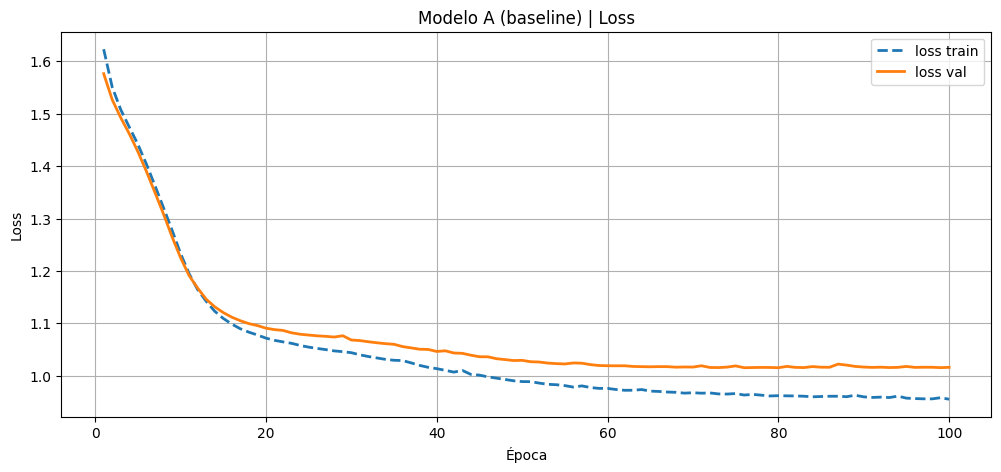

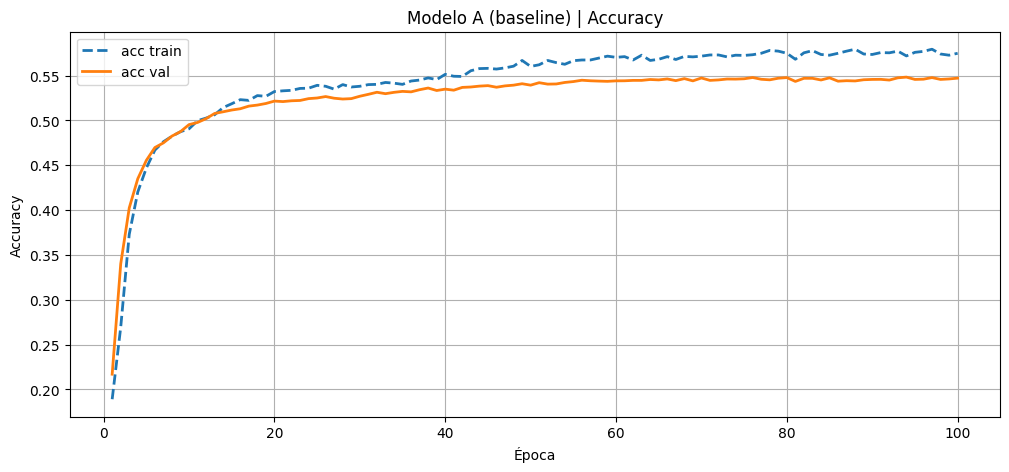

Confusion matrix (test):
[[1085  133  113   20    0]
 [ 362  185  218  122    0]
 [ 124  126  314  385    9]
 [  28   52  235  994   90]
 [   0    0    8  249  148]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.6785    0.8031    0.7356      1351
      passed     0.3730    0.2086    0.2675       887
        good     0.3536    0.3278    0.3402       958
       merit     0.5616    0.7105    0.6273      1399
   excellent     0.5992    0.3654    0.4540       405

    accuracy                         0.5452      5000
   macro avg     0.5132    0.4831    0.4849      5000
weighted avg     0.5229    0.5452    0.5237      5000



In [86]:
def build_model_A(input_dim, num_classes):
    #La entrada tiene como tamaño el número de columnas de x
    #Tiene dos capas densas de 30 neuronas con función de activación ReLU
    #La capa de salida tiene 5 neuronas con función de activación softmax
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation='relu')(entrada)
    x = tf.keras.layers.Dense(30, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloA = build_model_A(X_train.shape[1], num_classes)
modeloA.compile(
    #Optimizador Adam
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    #SparseCategorical se usa cuando son enteros
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    #la accuracy cuando la clase son números enteros
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyA = modeloA.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    verbose=1
)

plot_history(historyA, 'Modelo A (baseline)')
evalua_clasificacion(modeloA, X_test, y_test)


Epoch 1/300
15/15 [==============================] - 1s 29ms/step - loss: 1.6054 - accuracy: 0.2309 - val_loss: 1.5697 - val_accuracy: 0.3104
Epoch 2/300
15/15 [==============================] - 0s 8ms/step - loss: 1.5460 - accuracy: 0.3549 - val_loss: 1.5270 - val_accuracy: 0.3703
Epoch 3/300
15/15 [==============================] - 0s 9ms/step - loss: 1.5146 - accuracy: 0.3749 - val_loss: 1.5040 - val_accuracy: 0.3983
Epoch 4/300
15/15 [==============================] - 0s 8ms/step - loss: 1.4891 - accuracy: 0.4219 - val_loss: 1.4763 - val_accuracy: 0.4405
Epoch 5/300
15/15 [==============================] - 0s 8ms/step - loss: 1.4589 - accuracy: 0.4411 - val_loss: 1.4417 - val_accuracy: 0.4542
Epoch 6/300
15/15 [==============================] - 0s 8ms/step - loss: 1.4199 - accuracy: 0.4587 - val_loss: 1.3988 - val_accuracy: 0.4720
Epoch 7/300
15/15 [==============================] - 0s 9ms/step - loss: 1.3731 - accuracy: 0.4768 - val_loss: 1.3502 - val_accuracy: 0.4818
Epoch 8/300


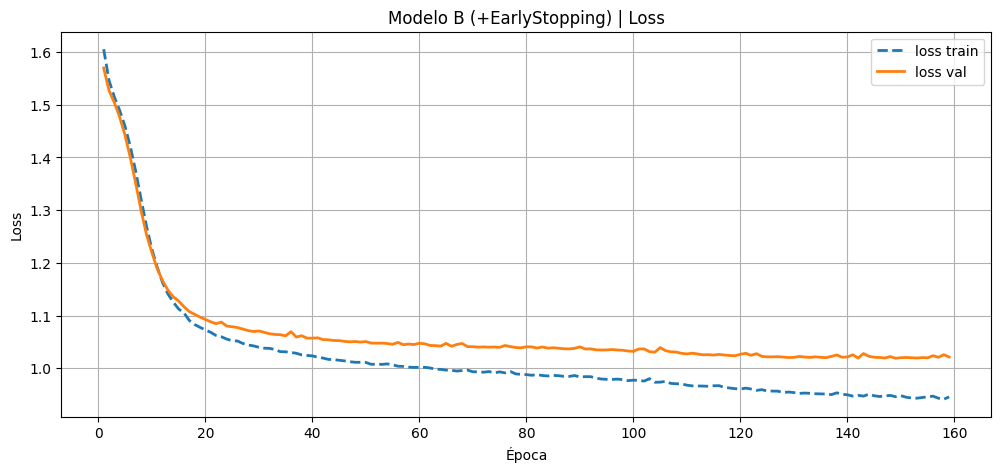

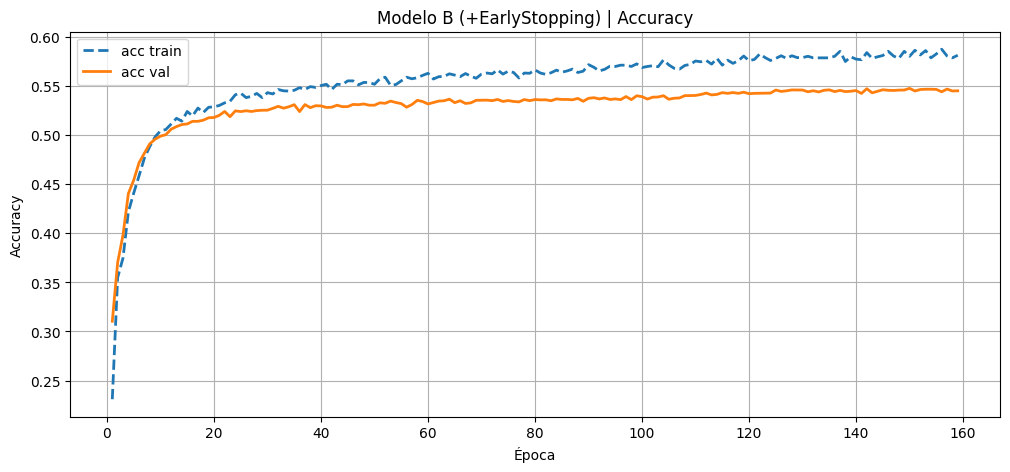

Confusion matrix (test):
[[1063  155  105   28    0]
 [ 344  217  188  138    0]
 [ 124  159  268  399    8]
 [  25   71  216  991   96]
 [   0    0    7  235  163]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.6832    0.7868    0.7313      1351
      passed     0.3605    0.2446    0.2915       887
        good     0.3418    0.2797    0.3077       958
       merit     0.5533    0.7084    0.6213      1399
   excellent     0.6105    0.4025    0.4851       405

    accuracy                         0.5404      5000
   macro avg     0.5099    0.4844    0.4874      5000
weighted avg     0.5183    0.5404    0.5214      5000



In [ ]:
modeloB = build_model_A(X_train.shape[1], num_classes)
modeloB.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyB = modeloB.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=256,
    callbacks=[cb_early],
    verbose=1
)

plot_history(historyB, 'Modelo B (+EarlyStopping)')
evalua_clasificacion(modeloB, X_test, y_test)

#Al añadir el número de épocas y el earlyStopping, mejoramos en un 1%


Epoch 1/300
15/15 [==============================] - 1s 23ms/step - loss: 1.5810 - accuracy: 0.2608 - val_loss: 1.5379 - val_accuracy: 0.3623
Epoch 2/300
15/15 [==============================] - 0s 10ms/step - loss: 1.5346 - accuracy: 0.3533 - val_loss: 1.4971 - val_accuracy: 0.4641
Epoch 3/300
15/15 [==============================] - 0s 15ms/step - loss: 1.4983 - accuracy: 0.3992 - val_loss: 1.4566 - val_accuracy: 0.4764
Epoch 4/300
15/15 [==============================] - 0s 12ms/step - loss: 1.4590 - accuracy: 0.4221 - val_loss: 1.4072 - val_accuracy: 0.4766
Epoch 5/300
15/15 [==============================] - 0s 10ms/step - loss: 1.4090 - accuracy: 0.4467 - val_loss: 1.3500 - val_accuracy: 0.4798
Epoch 6/300
15/15 [==============================] - 0s 10ms/step - loss: 1.3586 - accuracy: 0.4565 - val_loss: 1.2913 - val_accuracy: 0.4860
Epoch 7/300
15/15 [==============================] - 0s 13ms/step - loss: 1.3036 - accuracy: 0.4688 - val_loss: 1.2387 - val_accuracy: 0.4936
Epoch 

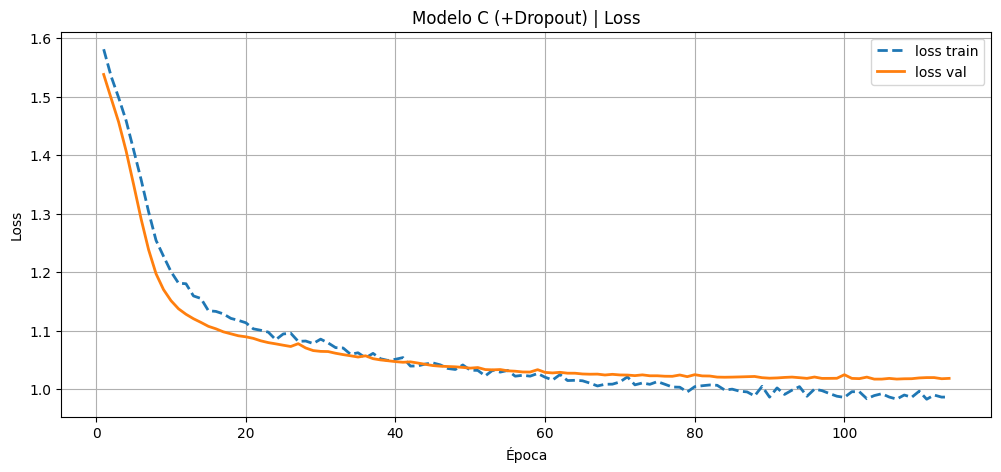

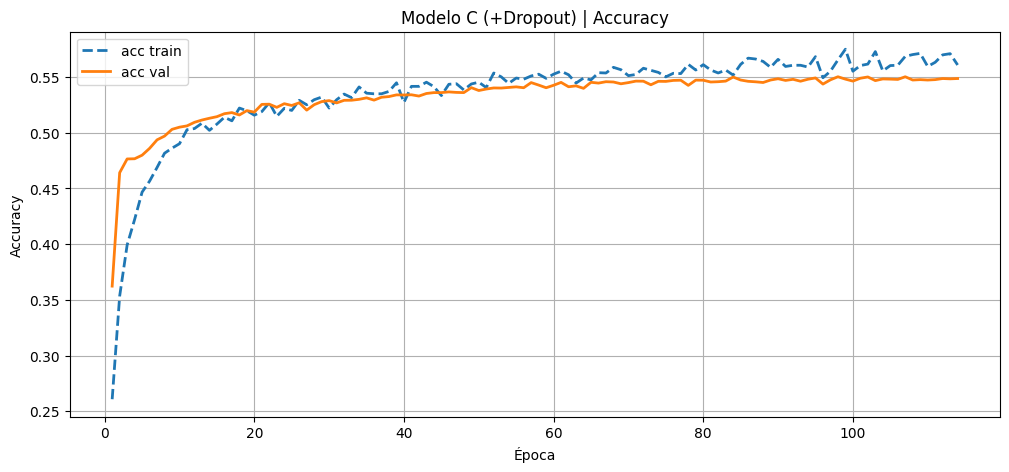

Confusion matrix (test):
[[1084  116  127   24    0]
 [ 364  173  212  138    0]
 [ 125  132  298  399    4]
 [  31   56  227 1027   58]
 [   0    0    7  279  119]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.6758    0.8024    0.7337      1351
      passed     0.3627    0.1950    0.2537       887
        good     0.3421    0.3111    0.3259       958
       merit     0.5501    0.7341    0.6289      1399
   excellent     0.6575    0.2938    0.4061       405

    accuracy                         0.5402      5000
   macro avg     0.5176    0.4673    0.4696      5000
weighted avg     0.5197    0.5402    0.5145      5000



In [ ]:
#Añadimos dropout
def build_model_C(input_dim, num_classes, dropout=0.25):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(64, activation='relu')(entrada)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloC = build_model_C(X_train.shape[1], num_classes, dropout=0.25)
modeloC.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyC = modeloC.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=256,
    callbacks=[cb_early],
    verbose=1
)

plot_history(historyC, 'Modelo C (+Dropout)')
evalua_clasificacion(modeloC, X_test, y_test)

#Empeoramos --> accuracy 56


Probamos con más capas

Epoch 1/400
15/15 [==============================] - 2s 40ms/step - loss: 1.5157 - accuracy: 0.3643 - val_loss: 1.3178 - val_accuracy: 0.4058 - lr: 0.0010
Epoch 2/400
15/15 [==============================] - 0s 19ms/step - loss: 1.1776 - accuracy: 0.4253 - val_loss: 1.1146 - val_accuracy: 0.4971 - lr: 0.0010
Epoch 3/400
15/15 [==============================] - 0s 19ms/step - loss: 1.1231 - accuracy: 0.4685 - val_loss: 1.1470 - val_accuracy: 0.4738 - lr: 0.0010
Epoch 4/400
15/15 [==============================] - 0s 19ms/step - loss: 1.0880 - accuracy: 0.4861 - val_loss: 1.1259 - val_accuracy: 0.4776 - lr: 0.0010
Epoch 5/400
15/15 [==============================] - 0s 19ms/step - loss: 1.0637 - accuracy: 0.4971 - val_loss: 1.1416 - val_accuracy: 0.4646 - lr: 0.0010
Epoch 6/400
15/15 [==============================] - 0s 19ms/step - loss: 1.0448 - accuracy: 0.5011 - val_loss: 1.1435 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 7/400
15/15 [==============================] - 0s 19ms/step - lo

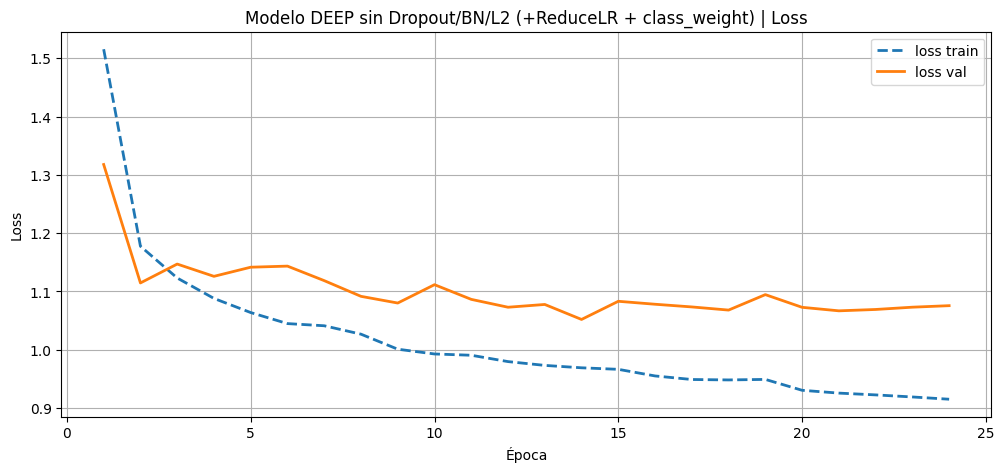

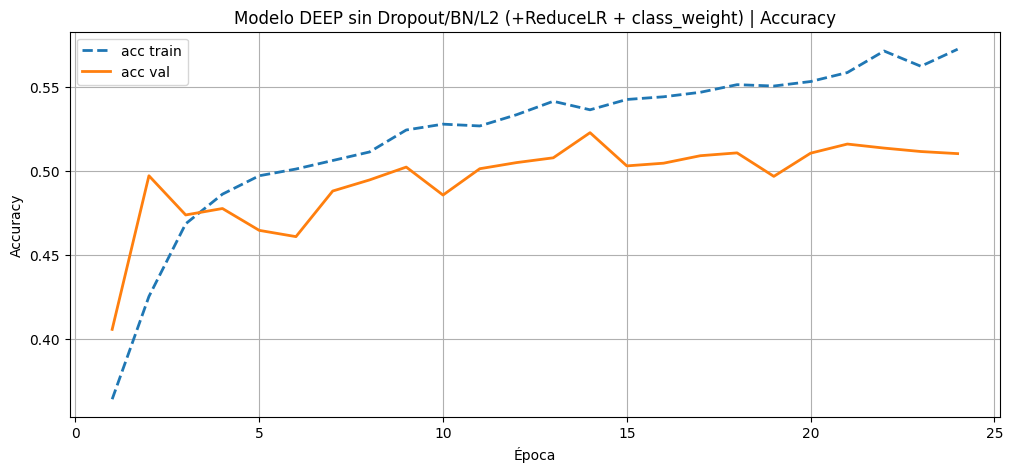

Confusion matrix (test):
[[922 337  77  15   0]
 [242 375 183  84   3]
 [ 65 269 309 285  30]
 [  8 128 284 757 222]
 [  0   0  15 159 231]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.7454    0.6825    0.7125      1351
      passed     0.3381    0.4228    0.3758       887
        good     0.3560    0.3225    0.3384       958
       merit     0.5823    0.5411    0.5609      1399
   excellent     0.4753    0.5704    0.5185       405

    accuracy                         0.5188      5000
   macro avg     0.4994    0.5078    0.5012      5000
weighted avg     0.5310    0.5188    0.5230      5000



In [ ]:
import tensorflow as tf

def build_model_DEEP_NO_DROPOUT_NO_BN_NO_L2(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))

    
    x = tf.keras.layers.Dense(256, activation='relu')(entrada)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloW = build_model_DEEP_NO_DROPOUT_NO_BN_NO_L2(X_train.shape[1], num_classes)

modeloW.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyW = modeloW.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=256,
    callbacks=[cb_early],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyW, 'Modelo DEEP sin Dropout/BN/L2 (+ReduceLR + class_weight)')
evalua_clasificacion(modeloW, X_test, y_test)

#Mejora muy poco, así que vamos a probar con más neuronas del base

Epoch 1/400
15/15 [==============================] - 1s 41ms/step - loss: 1.4721 - accuracy: 0.3373 - val_loss: 1.2786 - val_accuracy: 0.4391 - lr: 8.0000e-04
Epoch 2/400
15/15 [==============================] - 0s 25ms/step - loss: 1.1812 - accuracy: 0.4475 - val_loss: 1.2407 - val_accuracy: 0.4056 - lr: 8.0000e-04
Epoch 3/400
15/15 [==============================] - 0s 21ms/step - loss: 1.1160 - accuracy: 0.4648 - val_loss: 1.1763 - val_accuracy: 0.4436 - lr: 8.0000e-04
Epoch 4/400
15/15 [==============================] - 0s 28ms/step - loss: 1.0827 - accuracy: 0.4821 - val_loss: 1.1347 - val_accuracy: 0.4722 - lr: 8.0000e-04
Epoch 5/400
15/15 [==============================] - 0s 28ms/step - loss: 1.0660 - accuracy: 0.4979 - val_loss: 1.1300 - val_accuracy: 0.4708 - lr: 8.0000e-04
Epoch 6/400
15/15 [==============================] - 0s 33ms/step - loss: 1.0400 - accuracy: 0.5085 - val_loss: 1.1096 - val_accuracy: 0.4828 - lr: 8.0000e-04
Epoch 7/400
15/15 [===========================

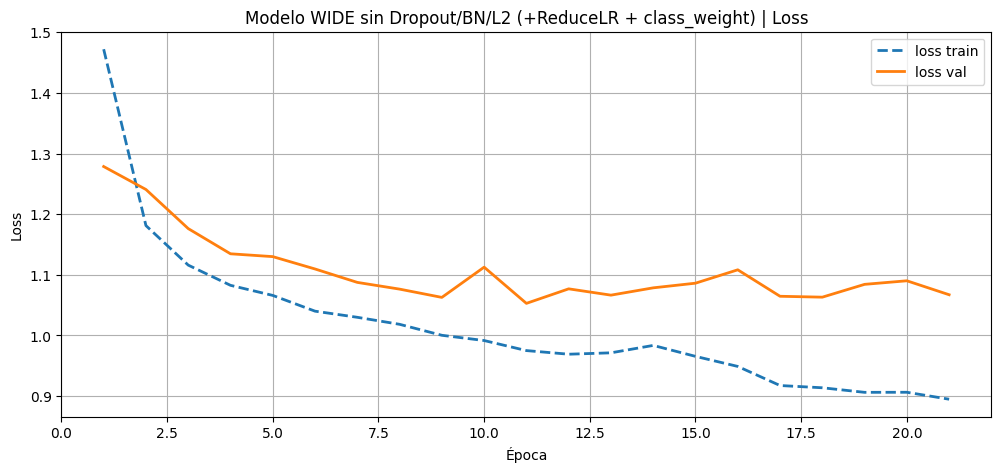

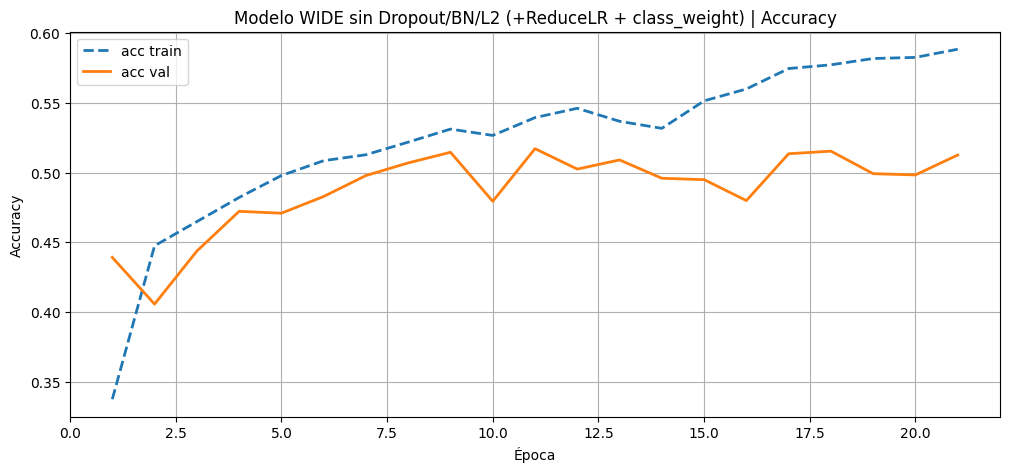

Confusion matrix (test):
[[1048  214   81    8    0]
 [ 317  291  207   69    3]
 [ 104  243  341  238   32]
 [  19  109  358  657  256]
 [   0    2   19  146  238]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.7043    0.7757    0.7383      1351
      passed     0.3388    0.3281    0.3333       887
        good     0.3390    0.3559    0.3473       958
       merit     0.5877    0.4696    0.5221      1399
   excellent     0.4499    0.5877    0.5096       405

    accuracy                         0.5150      5000
   macro avg     0.4839    0.5034    0.4901      5000
weighted avg     0.5162    0.5150    0.5125      5000



In [ ]:
import tensorflow as tf

def build_model_WIDE_NO_DROPOUT_NO_BN_NO_L2(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))

    # Misma profundidad (pocas capas), pero más neuronas por capa (más "ancho")
    x = tf.keras.layers.Dense(512, activation='relu')(entrada)
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    # opcional: capa intermedia ancha antes de softmax
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloW = build_model_WIDE_NO_DROPOUT_NO_BN_NO_L2(X_train.shape[1], num_classes)

modeloW.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyW = modeloW.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyW, 'Modelo WIDE sin Dropout/BN/L2 (+ReduceLR + class_weight)')
evalua_clasificacion(modeloW, X_test, y_test)

#mejora muy poco a más capas, probamos a meter más capas y neuronas


Epoch 1/400
15/15 [==============================] - 2s 54ms/step - loss: 1.4605 - accuracy: 0.2803 - val_loss: 1.2577 - val_accuracy: 0.4239 - lr: 8.0000e-04
Epoch 2/400
15/15 [==============================] - 1s 43ms/step - loss: 1.1586 - accuracy: 0.4693 - val_loss: 1.2412 - val_accuracy: 0.4153 - lr: 8.0000e-04
Epoch 3/400
15/15 [==============================] - 1s 39ms/step - loss: 1.1035 - accuracy: 0.4747 - val_loss: 1.2015 - val_accuracy: 0.4290 - lr: 8.0000e-04
Epoch 4/400
15/15 [==============================] - 1s 36ms/step - loss: 1.0849 - accuracy: 0.4776 - val_loss: 1.1071 - val_accuracy: 0.4879 - lr: 8.0000e-04
Epoch 5/400
15/15 [==============================] - 1s 36ms/step - loss: 1.0631 - accuracy: 0.4955 - val_loss: 1.1110 - val_accuracy: 0.4932 - lr: 8.0000e-04
Epoch 6/400
15/15 [==============================] - 1s 41ms/step - loss: 1.0309 - accuracy: 0.4992 - val_loss: 1.0906 - val_accuracy: 0.4988 - lr: 8.0000e-04
Epoch 7/400
15/15 [===========================

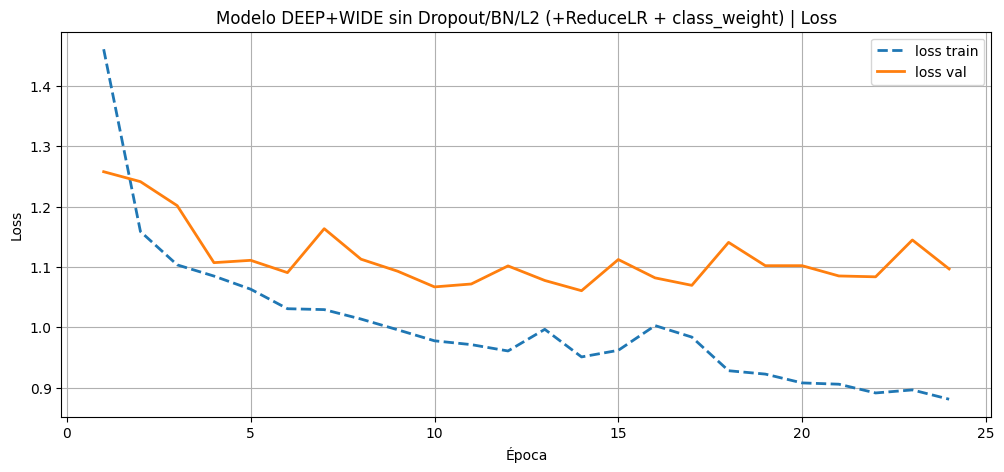

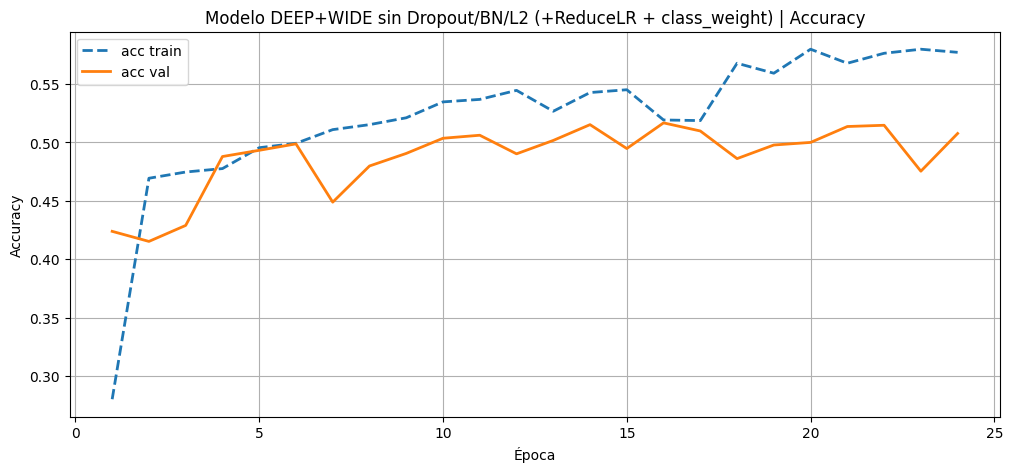

Confusion matrix (test):
[[948 318  74  11   0]
 [260 359 202  61   5]
 [ 72 275 331 236  44]
 [ 11 118 330 621 319]
 [  0   1  19 122 263]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.7343    0.7017    0.7176      1351
      passed     0.3352    0.4047    0.3667       887
        good     0.3462    0.3455    0.3459       958
       merit     0.5909    0.4439    0.5069      1399
   excellent     0.4168    0.6494    0.5077       405

    accuracy                         0.5044      5000
   macro avg     0.4847    0.5090    0.4890      5000
weighted avg     0.5233    0.5044    0.5082      5000



In [ ]:
import tensorflow as tf

def build_model_DEEP_WIDE_NO_DROPOUT_NO_BN_NO_L2(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))

    # Más capas y más neuronas, sin Dropout, sin BatchNorm, sin L2
    x = tf.keras.layers.Dense(512, activation='relu')(entrada)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)

    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloW = build_model_DEEP_WIDE_NO_DROPOUT_NO_BN_NO_L2(X_train.shape[1], num_classes)

modeloW.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyW = modeloW.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyW, 'Modelo DEEP+WIDE sin Dropout/BN/L2 (+ReduceLR + class_weight)')
evalua_clasificacion(modeloW, X_test, y_test)

#vemos que empeora el resultado, probamos a añadir aun más neuronas


Muchas neuronas

Epoch 1/400
15/15 [==============================] - 2s 86ms/step - loss: 1.4241 - accuracy: 0.3243 - val_loss: 1.3490 - val_accuracy: 0.4068 - lr: 8.0000e-04
Epoch 2/400
15/15 [==============================] - 1s 67ms/step - loss: 1.2366 - accuracy: 0.4248 - val_loss: 1.2075 - val_accuracy: 0.4191 - lr: 8.0000e-04
Epoch 3/400
15/15 [==============================] - 1s 69ms/step - loss: 1.1150 - accuracy: 0.4651 - val_loss: 1.2495 - val_accuracy: 0.4286 - lr: 8.0000e-04
Epoch 4/400
15/15 [==============================] - 1s 73ms/step - loss: 1.0773 - accuracy: 0.4899 - val_loss: 1.2142 - val_accuracy: 0.4316 - lr: 8.0000e-04
Epoch 5/400
15/15 [==============================] - 1s 68ms/step - loss: 1.0660 - accuracy: 0.4861 - val_loss: 1.1389 - val_accuracy: 0.4650 - lr: 8.0000e-04
Epoch 6/400
15/15 [==============================] - 1s 71ms/step - loss: 1.0255 - accuracy: 0.5128 - val_loss: 1.1498 - val_accuracy: 0.4710 - lr: 8.0000e-04
Epoch 7/400
15/15 [===========================

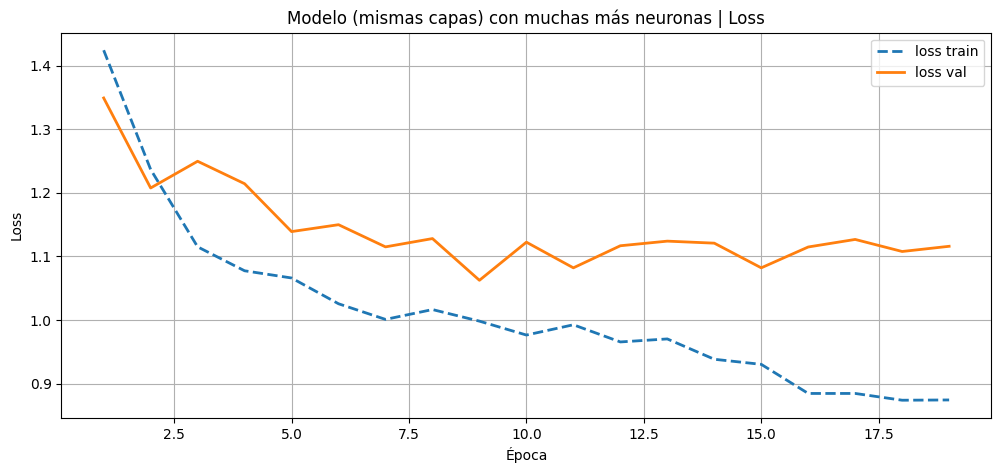

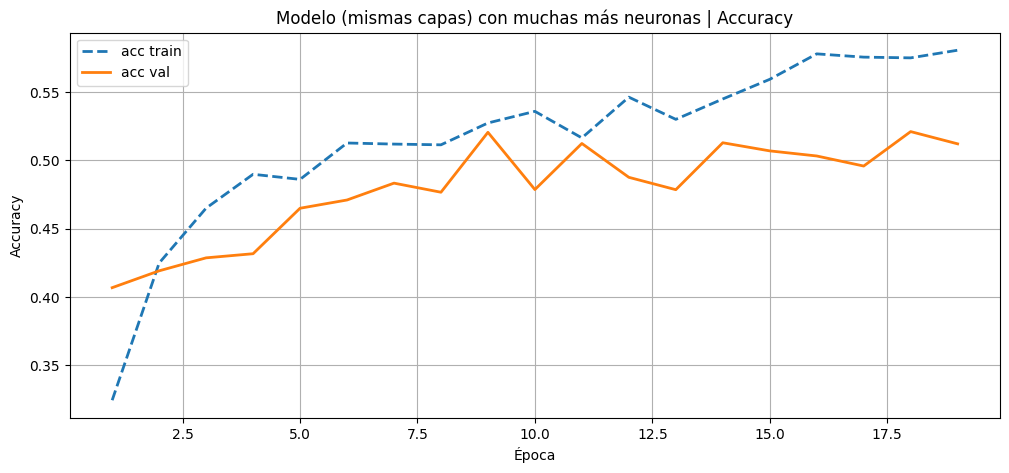

Confusion matrix (test):
[[954 289  85  23   0]
 [246 340 191 102   8]
 [ 68 229 325 294  42]
 [ 15  94 269 730 291]
 [  0   0   8 142 255]]

Classification report (test):
              precision    recall  f1-score   support

      failed     0.7436    0.7061    0.7244      1351
      passed     0.3571    0.3833    0.3698       887
        good     0.3702    0.3392    0.3540       958
       merit     0.5655    0.5218    0.5428      1399
   excellent     0.4279    0.6296    0.5095       405

    accuracy                         0.5208      5000
   macro avg     0.4928    0.5160    0.5001      5000
weighted avg     0.5281    0.5208    0.5223      5000



In [95]:
import tensorflow as tf

def build_model_DEEP_WIDE_MORE_NEURONS_NO_DROPOUT_NO_BN_NO_L2(input_dim, num_classes):
    entrada = tf.keras.layers.Input(shape=(input_dim,))

    # MISMAS capas que antes (6 densas antes de softmax), pero MÁS neuronas
    x = tf.keras.layers.Dense(1024, activation='relu')(entrada)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)

    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloW = build_model_DEEP_WIDE_MORE_NEURONS_NO_DROPOUT_NO_BN_NO_L2(X_train.shape[1], num_classes)

modeloW.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyW = modeloW.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyW, 'Modelo (mismas capas) con muchas más neuronas')
evalua_clasificacion(modeloW, X_test, y_test)


Despues de esto, nos queda probar con varias estructuras, optimizadores, dropouts y learning rates

In [98]:
import time
import itertools
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Utilidades (igual idea que antes)
# -----------------------------
def evalua_clasificacion(modelo, X_test, y_test, class_names):
    probs = modelo.predict(X_test, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    print("Confusion matrix (test):")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

def build_mlp(input_dim, num_classes, hidden_units, dropout=0.0):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = entrada
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation="relu")(x)
        if dropout and dropout > 0:
            x = tf.keras.layers.Dropout(dropout)(x)
    salida = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

def make_optimizer(name, lr):
    name = name.lower()
    if name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    if name == "adamw":
        # si no está disponible en tu TF, cae a Adam
        try:
            return tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
        except Exception:
            return tf.keras.optimizers.Adam(learning_rate=lr)
    raise ValueError(f"Optimizador no soportado: {name}")

# -----------------------------
# GridSearch manual con SOLO EarlyStopping y límite de tiempo (<= 20 min)
# -----------------------------
def grid_search_mlp_timeboxed(
    X_train, y_train, X_val, y_val,
    input_dim, num_classes,
    class_weights=None,
    seed=42,
    time_budget_minutes=20,
    max_trials=10_000,       # además del tiempo, por si quieres capear por nº de pruebas
    max_epochs=120,          # para que no se alargue demasiado cada trial
    batch_size=256,
    patience=5,              # baja si quieres que corte antes
    monitor="val_loss"
):
    tf.keras.utils.set_random_seed(seed)

    # ÚNICO callback permitido: EarlyStopping
    cb_early = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=True
    )

    # Espacio de búsqueda (ajusta a tu gusto)
    grid_hidden_units = [
        [128, 128],
        [256, 256],
        [512, 256],
        [512, 512],
        [512, 512, 256],
        [1024, 512, 256],
    ]
    grid_dropouts = [0.0, 0.3]
    grid_optimizers = ["adam", "adamw", "sgd"]
    grid_lrs = [1e-3, 1e-4]

    combos = list(itertools.product(grid_hidden_units, grid_dropouts, grid_optimizers, grid_lrs))
    total_combos = len(combos)

    budget_secs = time_budget_minutes * 60
    t0 = time.time()

    results = []
    best_overall = None

    trial = 0
    for hidden_units, dropout, opt_name, lr in combos:
        # Corte por tiempo
        if (time.time() - t0) >= budget_secs:
            print(f"\n[STOP] Presupuesto de tiempo alcanzado (≈ {time_budget_minutes} min).")
            break

        # Corte por nº de pruebas
        if trial >= max_trials:
            print(f"\n[STOP] Límite de pruebas alcanzado (max_trials={max_trials}).")
            break

        trial += 1
        tf.keras.backend.clear_session()

        model = build_mlp(input_dim, num_classes, hidden_units, dropout=dropout)
        model.compile(
            optimizer=make_optimizer(opt_name, lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=[cb_early],            # SOLO EarlyStopping
            class_weight=class_weights,
            verbose=0
        )

        # Como restore_best_weights=True, el modelo acaba con los mejores pesos según monitor.
        # Para reportar "mejor epoch", lo inferimos del history:
        h = history.history
        if "val_loss" in h and len(h["val_loss"]) > 0:
            best_idx = int(np.argmin(h["val_loss"]))
            best_val_loss = float(h["val_loss"][best_idx])
            best_val_acc = float(h.get("val_accuracy", [np.nan]*len(h["val_loss"]))[best_idx])
            best_epoch = best_idx + 1
        else:
            best_val_loss = np.inf
            best_val_acc = np.nan
            best_epoch = None

        row = {
            "hidden_units": tuple(hidden_units),
            "dropout": float(dropout),
            "optimizer": opt_name,
            "lr": float(lr),
            "trained_epochs": len(h.get("loss", [])),
            "best_epoch": best_epoch,
            "best_val_loss": best_val_loss,
            "best_val_accuracy": best_val_acc,
            "best_weights": model.get_weights(),   # son los mejores por EarlyStopping
        }
        results.append(row)

        if (best_overall is None) or (best_val_loss < best_overall["best_val_loss"]):
            best_overall = row

        elapsed = time.time() - t0
        print(
            f"[{trial:>3}/{total_combos}] units={hidden_units}, drop={dropout}, opt={opt_name}, lr={lr} "
            f"-> best_val_loss={best_val_loss:.5f}, best_val_acc={best_val_acc:.5f}, "
            f"epochs={row['trained_epochs']} | elapsed={elapsed/60:.1f}m"
        )

    results_sorted = sorted(results, key=lambda d: d["best_val_loss"])
    return results_sorted, best_overall

# -----------------------------
# Ejecución + evaluación del mejor en TEST
# -----------------------------
# Asume que ya tienes: X_train, y_train, X_val, y_val, X_test, y_test, class_weights, class_names, num_classes

results_sorted, best = grid_search_mlp_timeboxed(
    X_train, y_train, X_val, y_val,
    input_dim=X_train.shape[1],
    num_classes=num_classes,
    class_weights=class_weights,     # pon None si no quieres
    time_budget_minutes=20,          # <= 20 minutos
    max_epochs=120,                  # baja a 60-80 si va lento
    patience=8,                      # baja a 5 si quieres cortar antes
    batch_size=256
)

print("\nTOP 10 configs por val_loss (de lo que haya dado tiempo a probar):")
for i, r in enumerate(results_sorted[:10], start=1):
    print(
        f"{i:>2}. units={list(r['hidden_units'])} drop={r['dropout']} opt={r['optimizer']} lr={r['lr']} "
        f"| best_val_loss={r['best_val_loss']:.5f} best_val_acc={r['best_val_accuracy']:.5f} "
        f"best_epoch={r['best_epoch']} trained_epochs={r['trained_epochs']}"
    )

# Reconstruir el mejor y evaluar en TEST
tf.keras.backend.clear_session()
best_model = build_mlp(X_train.shape[1], num_classes, list(best["hidden_units"]), dropout=best["dropout"])
best_model.compile(
    optimizer=make_optimizer(best["optimizer"], best["lr"]),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
)
best_model.set_weights(best["best_weights"])

print("\nMejor configuración final (según val_loss):")
print(best["hidden_units"], "drop=", best["dropout"], "opt=", best["optimizer"], "lr=", best["lr"])
evalua_clasificacion(best_model, X_test, y_test, class_names)


[  1/72] units=[128, 128], drop=0.0, opt=adam, lr=0.001 -> best_val_loss=1.05792, best_val_acc=0.51360, epochs=47 | elapsed=0.1m
[  2/72] units=[128, 128], drop=0.0, opt=adam, lr=0.0001 -> best_val_loss=1.11230, best_val_acc=0.48613, epochs=117 | elapsed=0.4m
[  3/72] units=[128, 128], drop=0.0, opt=adamw, lr=0.001 -> best_val_loss=1.06945, best_val_acc=0.50987, epochs=45 | elapsed=0.5m
[  4/72] units=[128, 128], drop=0.0, opt=adamw, lr=0.0001 -> best_val_loss=1.10525, best_val_acc=0.48818, epochs=120 | elapsed=0.8m
[  5/72] units=[128, 128], drop=0.0, opt=sgd, lr=0.001 -> best_val_loss=1.58308, best_val_acc=0.27973, epochs=9 | elapsed=0.9m
[  6/72] units=[128, 128], drop=0.0, opt=sgd, lr=0.0001 -> best_val_loss=1.56860, best_val_acc=0.29618, epochs=120 | elapsed=4.0m
[  7/72] units=[128, 128], drop=0.3, opt=adam, lr=0.001 -> best_val_loss=1.06376, best_val_acc=0.50649, epochs=66 | elapsed=4.3m
[  8/72] units=[128, 128], drop=0.3, opt=adam, lr=0.0001 -> best_val_loss=1.13257, best_val_

In [100]:
import time, itertools, pickle
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Utilidades
# -----------------------------
def evalua_clasificacion(modelo, X_test, y_test, class_names):
    probs = modelo.predict(X_test, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    print("Confusion matrix (test):")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

def build_mlp(input_dim, num_classes, hidden_units, dropout=0.0):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = entrada
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation="relu")(x)
        if dropout and dropout > 0:
            x = tf.keras.layers.Dropout(dropout)(x)
    salida = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

def make_optimizer(name, lr):
    name = name.lower()
    if name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if name == "adamw":
        try:
            return tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
        except Exception:
            return tf.keras.optimizers.Adam(learning_rate=lr)
    if name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    raise ValueError(f"Optimizador no soportado: {name}")

def save_progress(path, state):
    with open(path, "wb") as f:
        pickle.dump(state, f)

def load_progress(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# -----------------------------
# Reanudar la búsqueda EXACTAMENTE donde se quedó
# (mismas grids y mismo orden que tu salida: 72 combos)
# -----------------------------
def resume_grid_search(
    X_train, y_train, X_val, y_val, X_test, y_test,
    input_dim, num_classes,
    class_names,
    class_weights=None,
    progress_path="grid_progress.pkl",
    time_budget_minutes=20,
    max_epochs=120,
    batch_size=256,
    patience=8,
    resume_from_trial=None,   # si NO hay fichero de progreso, pon 41 para continuar desde el 42
    seed=42
):
    tf.keras.utils.set_random_seed(seed)

    # ÚNICO callback: EarlyStopping
    cb_early = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )

    # Estas grids deben coincidir con las que ya corriste (por tu log)
    grid_hidden_units = [
        [128, 128],
        [256, 256],
        [512, 256],
        [512, 512],
        [512, 512, 256],
        [1024, 512, 256],
    ]
    grid_dropouts = [0.0, 0.3]
    grid_optimizers = ["adam", "adamw", "sgd"]
    grid_lrs = [1e-3, 1e-4]

    combos = list(itertools.product(grid_hidden_units, grid_dropouts, grid_optimizers, grid_lrs))
    total = len(combos)  # 72

    # Cargar progreso si existe
    try:
        state = load_progress(progress_path)
        results = state["results"]
        best = state["best"]
        start_idx = state["next_idx"]
        print(f"[RESUME] Progreso cargado: {start_idx}/{total} completados.")
    except Exception:
        results = []
        best = None
        if resume_from_trial is None:
            raise ValueError("No hay progreso guardado. Pasa resume_from_trial=41 para continuar desde el 42.")
        # resume_from_trial es el número mostrado en tu log (1-indexed). Para empezar en el siguiente:
        start_idx = int(resume_from_trial)  # 41 -> start_idx=41 (0-indexed), siguiente será combos[41] => trial 42
        print(f"[RESUME] Sin fichero. Reanudando desde trial {resume_from_trial+1}/{total}.")

    t0 = time.time()
    budget_secs = time_budget_minutes * 60

    for idx in range(start_idx, total):
        if (time.time() - t0) >= budget_secs:
            print(f"\n[STOP] Presupuesto de tiempo alcanzado (≈ {time_budget_minutes} min).")
            break

        hidden_units, dropout, opt_name, lr = combos[idx]
        tf.keras.backend.clear_session()

        model = build_mlp(input_dim, num_classes, hidden_units, dropout=dropout)
        model.compile(
            optimizer=make_optimizer(opt_name, lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=[cb_early],
            class_weight=class_weights,
            verbose=0
        )

        h = history.history
        best_idx = int(np.argmin(h["val_loss"]))
        row = {
            "hidden_units": tuple(hidden_units),
            "dropout": float(dropout),
            "optimizer": opt_name,
            "lr": float(lr),
            "trained_epochs": len(h["loss"]),
            "best_epoch": best_idx + 1,
            "best_val_loss": float(h["val_loss"][best_idx]),
            "best_val_accuracy": float(h["val_accuracy"][best_idx]) if "val_accuracy" in h else float("nan"),
            "best_weights": model.get_weights(),
        }
        results.append(row)

        if (best is None) or (row["best_val_loss"] < best["best_val_loss"]):
            best = row

        elapsed = (time.time() - t0) / 60
        print(
            f"[{idx+1:>3}/{total}] units={hidden_units}, drop={dropout}, opt={opt_name}, lr={lr} "
            f"-> best_val_loss={row['best_val_loss']:.5f}, best_val_acc={row['best_val_accuracy']:.5f}, "
            f"epochs={row['trained_epochs']} | elapsed={elapsed:.1f}m"
        )

        # Guardar progreso tras cada trial
        save_progress(progress_path, {"results": results, "best": best, "next_idx": idx + 1})

    # Ordenar y mostrar top
    results_sorted = sorted(results, key=lambda d: d["best_val_loss"])
    print("\nTOP 10 configs por val_loss (acumulado):")
    for i, r in enumerate(results_sorted[:10], start=1):
        print(
            f"{i:>2}. units={list(r['hidden_units'])} drop={r['dropout']} opt={r['optimizer']} lr={r['lr']} "
            f"| best_val_loss={r['best_val_loss']:.5f} best_val_acc={r['best_val_accuracy']:.5f} "
            f"best_epoch={r['best_epoch']} trained_epochs={r['trained_epochs']}"
        )

    # Evaluar mejor en TEST
    tf.keras.backend.clear_session()
    best_model = build_mlp(input_dim, num_classes, list(best["hidden_units"]), dropout=best["dropout"])
    best_model.compile(
        optimizer=make_optimizer(best["optimizer"], best["lr"]),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    )
    best_model.set_weights(best["best_weights"])

    print("\nMejor configuración actual (según val_loss):")
    print(best["hidden_units"], "drop=", best["dropout"], "opt=", best["optimizer"], "lr=", best["lr"])
    evalua_clasificacion(best_model, X_test, y_test, class_names)

    return results_sorted, best

# -----------------------------
# USO
# -----------------------------
# Si guardaste el fichero grid_progress.pkl en la ejecución anterior:
# results_sorted, best = resume_grid_search(...)

# Si NO guardaste progreso y quieres continuar desde tu último trial impreso (41):
results_sorted, best = resume_grid_search(
    X_train, y_train, X_val, y_val, X_test, y_test,
    input_dim=X_train.shape[1],
    num_classes=num_classes,
    class_names=class_names,
    class_weights=class_weights,
    time_budget_minutes=20,
    resume_from_trial=41
)


[RESUME] Sin fichero. Reanudando desde trial 42/72.
[ 42/72] units=[512, 512], drop=0.0, opt=sgd, lr=0.0001 -> best_val_loss=1.57785, best_val_acc=0.32311, epochs=120 | elapsed=0.8m
[ 43/72] units=[512, 512], drop=0.3, opt=adam, lr=0.001 -> best_val_loss=1.05496, best_val_acc=0.51911, epochs=25 | elapsed=1.0m
[ 44/72] units=[512, 512], drop=0.3, opt=adam, lr=0.0001 -> best_val_loss=1.10012, best_val_acc=0.49031, epochs=74 | elapsed=1.6m
[ 45/72] units=[512, 512], drop=0.3, opt=adamw, lr=0.001 -> best_val_loss=1.05625, best_val_acc=0.51609, epochs=28 | elapsed=1.8m
[ 46/72] units=[512, 512], drop=0.3, opt=adamw, lr=0.0001 -> best_val_loss=1.08511, best_val_acc=0.49787, epochs=106 | elapsed=2.7m
[ 47/72] units=[512, 512], drop=0.3, opt=sgd, lr=0.001 -> best_val_loss=1.17934, best_val_acc=0.45698, epochs=120 | elapsed=3.7m
[ 48/72] units=[512, 512], drop=0.3, opt=sgd, lr=0.0001 -> best_val_loss=1.58930, best_val_acc=0.27449, epochs=120 | elapsed=4.6m
[ 49/72] units=[512, 512, 256], drop=0

Procedemos a clasificar si ha aprobado o no. Después de los malos resultados tratamos de predecir si el estudiante ha suspendido o aprobado

Distribución train: {0: 3040, 1: 8210}
class_weights: {0: 1.850328947368421, 1: 0.6851400730816078}
Epoch 1/100
44/44 [==============================] - 2s 13ms/step - loss: 0.6545 - accuracy: 0.7468 - val_loss: 0.5856 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 0.5449 - accuracy: 0.7949 - val_loss: 0.4561 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 0.4353 - accuracy: 0.8062 - val_loss: 0.3839 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 0.3914 - accuracy: 0.8140 - val_loss: 0.3984 - val_accuracy: 0.8197 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.3802 - accuracy: 0.8156 - val_loss: 0.3718 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 0s 7ms/step - loss: 0.3742 - accuracy: 0.8212 - val_loss: 0.3806 - val_accur

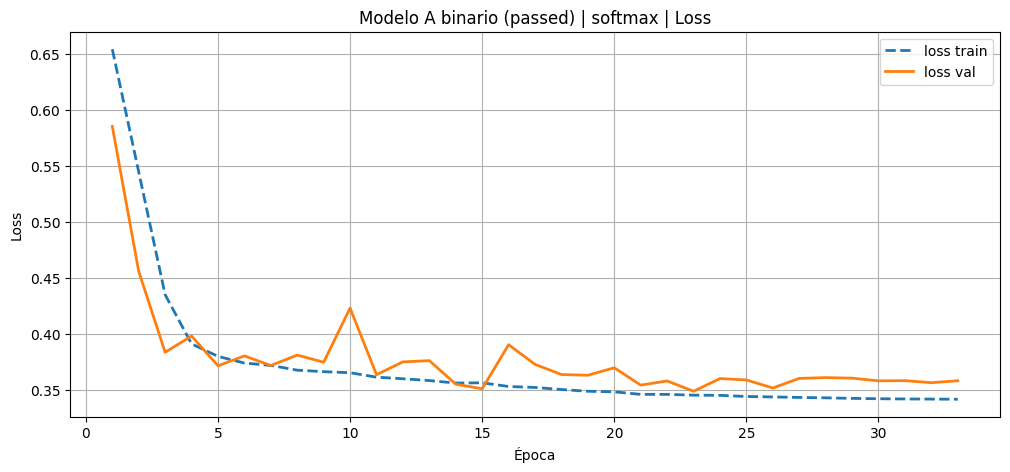

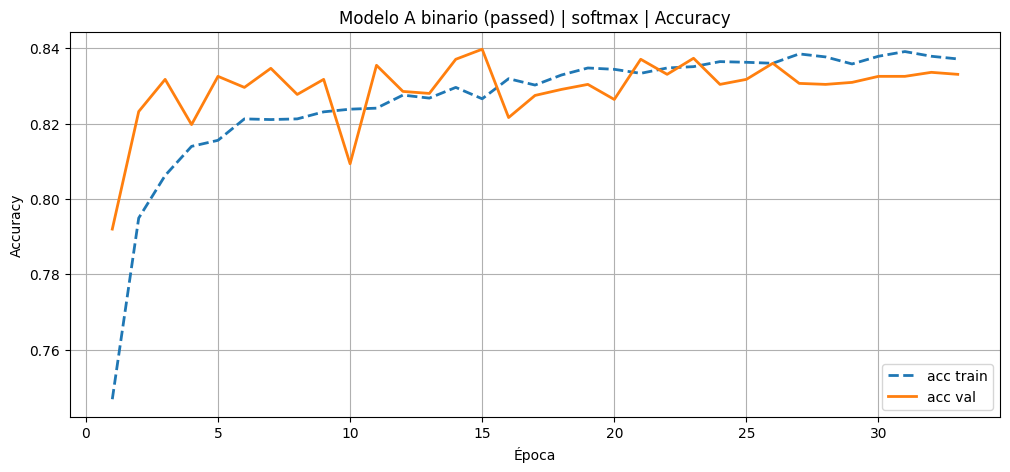

Confusion matrix (test):
[[1116  235]
 [ 597 3052]]

Classification report (test):
              precision    recall  f1-score   support

   no_passed     0.6515    0.8261    0.7285      1351
      passed     0.9285    0.8364    0.8800      3649

    accuracy                         0.8336      5000
   macro avg     0.7900    0.8312    0.8043      5000
weighted avg     0.8537    0.8336    0.8391      5000



In [102]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1) X (predictoras) y y (binary: passed)
# -----------------------------
# X: variables predictoras (escaladas)
X = datos_estudiantes_scaled.drop(['exam_score', 'passed', 'mark'], axis=1)

# y: etiqueta binaria (NO escalada) tomada del dataframe original
y_raw = datos_estudiantes['passed'].copy()

# Si 'passed' viene como texto/boolean, lo convertimos a 0/1
# Ajusta el mapeo si tus valores reales son distintos
mapa_passed = {
    'no': 0, 'No': 0, 'NO': 0,
    'false': 0, 'False': 0, False: 0,
    '0': 0, 0: 0,
    'yes': 1, 'Yes': 1, 'YES': 1,
    'true': 1, 'True': 1, True: 1,
    '1': 1, 1: 1,
    'passed': 1, 'failed': 0
}

if y_raw.dtype == object or str(y_raw.dtype).startswith("bool"):
    y = y_raw.map(mapa_passed).astype(int).to_numpy()
else:
    # si ya es numérico
    y = y_raw.astype(int).to_numpy()

class_names = ['no_passed', 'passed']
num_classes = 2  # para softmax binario

# -----------------------------
# 2) Split estratificado: train/val/test
# -----------------------------
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------
# 3) Pesos por clase (recomendable si hay desbalance 0/1)
# -----------------------------
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

print('Distribución train:', dict(zip(*np.unique(y_train, return_counts=True))))
print('class_weights:', class_weights)

# -----------------------------
# 4) Plot + evaluación
# -----------------------------
import matplotlib.pyplot as plt

def plot_history(history, titulo):
    h = history.history
    epochs = np.arange(1, len(h['loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['loss'], '--', linewidth=2, label='loss train')
    plt.plot(epochs, h['val_loss'], '-', linewidth=2, label='loss val')
    plt.title(titulo + ' | Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.grid(True)
    plt.plot(epochs, h['accuracy'], '--', linewidth=2, label='acc train')
    plt.plot(epochs, h['val_accuracy'], '-', linewidth=2, label='acc val')
    plt.title(titulo + ' | Accuracy')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evalua_clasificacion(modelo, X_test, y_test):
    probs = modelo.predict(X_test, verbose=0)          # (N,2)
    y_pred = np.argmax(probs, axis=1)                  # 0/1

    print('Confusion matrix (test):')
    print(confusion_matrix(y_test, y_pred))

    print('\nClassification report (test):')
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

# -----------------------------
# 5) Callbacks
# -----------------------------
cb_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# (si quieres mantenerlo, perfecto; si no, elimínalo)
cb_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
)

# -----------------------------
# 6) Modelo baseline (binario) con Softmax 2 clases + SparseCategorical
# -----------------------------
def build_model_A_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation='relu')(entrada)
    x = tf.keras.layers.Dense(30, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

modeloA = build_model_A_binary_softmax(X_train.shape[1], num_classes)

modeloA.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

historyA = modeloA.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,   # pon None si no lo quieres
    verbose=1
)

plot_history(historyA, 'Modelo A binario (passed) | softmax')
evalua_clasificacion(modeloA, X_test, y_test)


Epoch 1/100
44/44 [==============================] - 1s 13ms/step - loss: 0.6718 - accuracy: 0.6121 - val_loss: 0.6185 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 0.5615 - accuracy: 0.7613 - val_loss: 0.4544 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 0s 5ms/step - loss: 0.4397 - accuracy: 0.8057 - val_loss: 0.3890 - val_accuracy: 0.8243 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 0.3895 - accuracy: 0.8156 - val_loss: 0.3995 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 0.3787 - accuracy: 0.8187 - val_loss: 0.3722 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 0s 5ms/step - loss: 0.3742 - accuracy: 0.8229 - val_loss: 0.3819 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 0s 7ms/step - loss: 0.

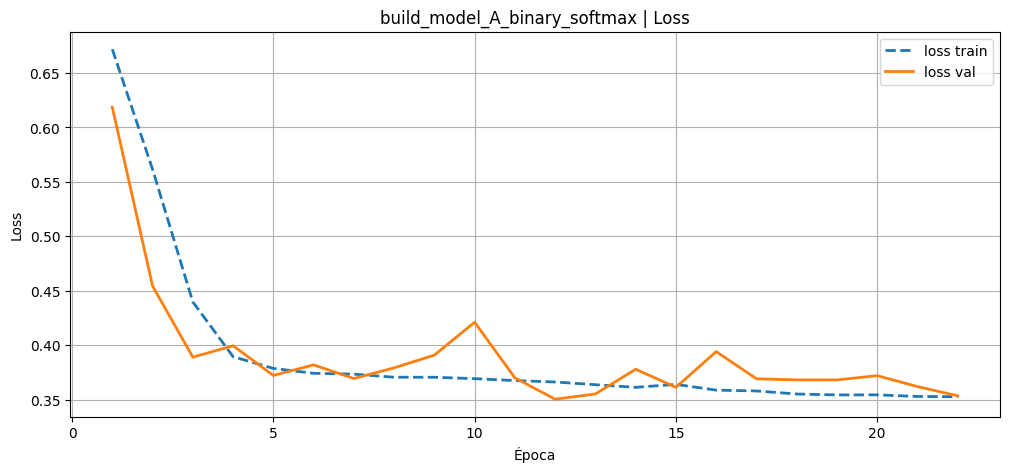

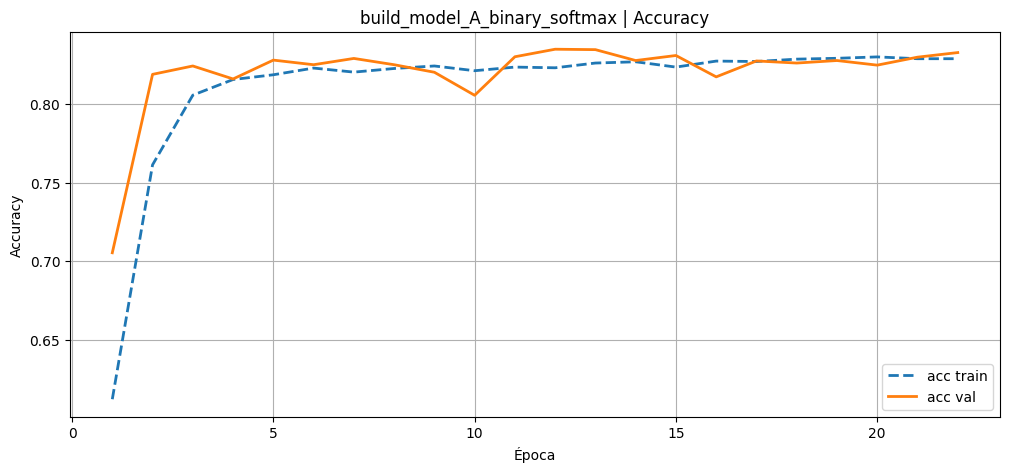

Confusion matrix (test):
[[1083  268]
 [ 574 3075]]

Classification report (test):
              precision    recall  f1-score   support

   no_passed     0.6536    0.8016    0.7201      1351
      passed     0.9198    0.8427    0.8796      3649

    accuracy                         0.8316      5000
   macro avg     0.7867    0.8222    0.7998      5000
weighted avg     0.8479    0.8316    0.8365      5000



In [103]:
import tensorflow as tf

# ============================================================
# CLASIFICACIÓN BINARIA (passed) - variantes de arquitectura
# MISMA IDEA que antes: si usas softmax(2) -> SparseCategorical
# ============================================================

# 1) Baseline (equivalente a tu Modelo A pero binario)
def build_model_A_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(30, activation='relu')(entrada)
    x = tf.keras.layers.Dense(30, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# 2) MÁS CAPAS (deep), mismas neuronas “moderadas” (ejemplo tipo DEEP)
def build_model_DEEP_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(256, activation='relu')(entrada)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# 3) MÁS NEURONAS (wide), SIN aumentar capas respecto a “estructura simple”
def build_model_WIDE_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(512, activation='relu')(entrada)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# 4) MÁS CAPAS Y MÁS NEURONAS (deep + wide)
def build_model_DEEP_WIDE_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(512, activation='relu')(entrada)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# 5) MISMAS CAPAS que el deep+wide anterior, pero AÚN MÁS NEURONAS
def build_model_DEEP_WIDE_MORE_NEURONS_binary_softmax(input_dim, num_classes=2):
    entrada = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(1024, activation='relu')(entrada)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    salida = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=entrada, outputs=salida)

# ============================================================
# EJEMPLO DE USO (cambia la función build_model_... que quieras)
# ============================================================
modelo = build_model_A_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_A_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)


Epoch 1/100
44/44 [==============================] - 2s 22ms/step - loss: 0.4502 - accuracy: 0.7981 - val_loss: 0.3486 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 1s 13ms/step - loss: 0.3754 - accuracy: 0.8188 - val_loss: 0.3535 - val_accuracy: 0.8291 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 1s 13ms/step - loss: 0.3550 - accuracy: 0.8279 - val_loss: 0.3765 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 1s 13ms/step - loss: 0.3465 - accuracy: 0.8340 - val_loss: 0.3331 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 1s 14ms/step - loss: 0.3409 - accuracy: 0.8335 - val_loss: 0.3493 - val_accuracy: 0.8357 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 1s 12ms/step - loss: 0.3456 - accuracy: 0.8368 - val_loss: 0.3413 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 1s 14ms/step - lo

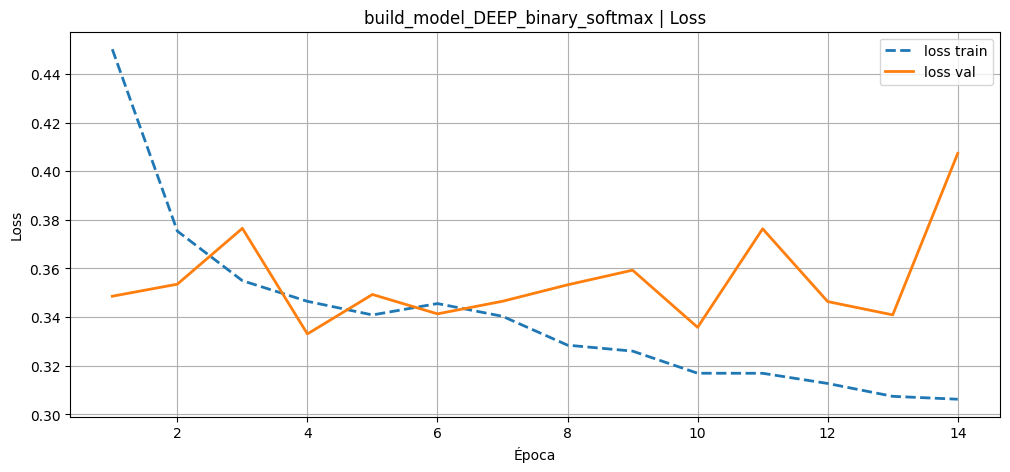

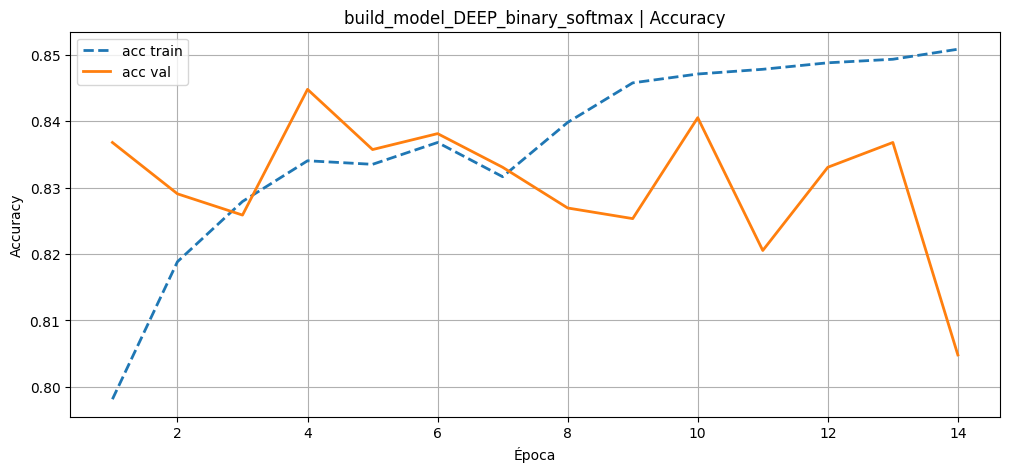

Confusion matrix (test):
[[1092  259]
 [ 535 3114]]

Classification report (test):
              precision    recall  f1-score   support

   no_passed     0.6712    0.8083    0.7334      1351
      passed     0.9232    0.8534    0.8869      3649

    accuracy                         0.8412      5000
   macro avg     0.7972    0.8308    0.8102      5000
weighted avg     0.8551    0.8412    0.8454      5000



In [104]:
modelo = build_model_DEEP_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_DEEP_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)

Epoch 1/100
44/44 [==============================] - 2s 20ms/step - loss: 0.4404 - accuracy: 0.8032 - val_loss: 0.3557 - val_accuracy: 0.8384 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 1s 16ms/step - loss: 0.3690 - accuracy: 0.8230 - val_loss: 0.3519 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 1s 15ms/step - loss: 0.3540 - accuracy: 0.8301 - val_loss: 0.3834 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 1s 16ms/step - loss: 0.3451 - accuracy: 0.8362 - val_loss: 0.3199 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 1s 16ms/step - loss: 0.3490 - accuracy: 0.8316 - val_loss: 0.4053 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 1s 13ms/step - loss: 0.3440 - accuracy: 0.8341 - val_loss: 0.3277 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 1s 16ms/step - lo

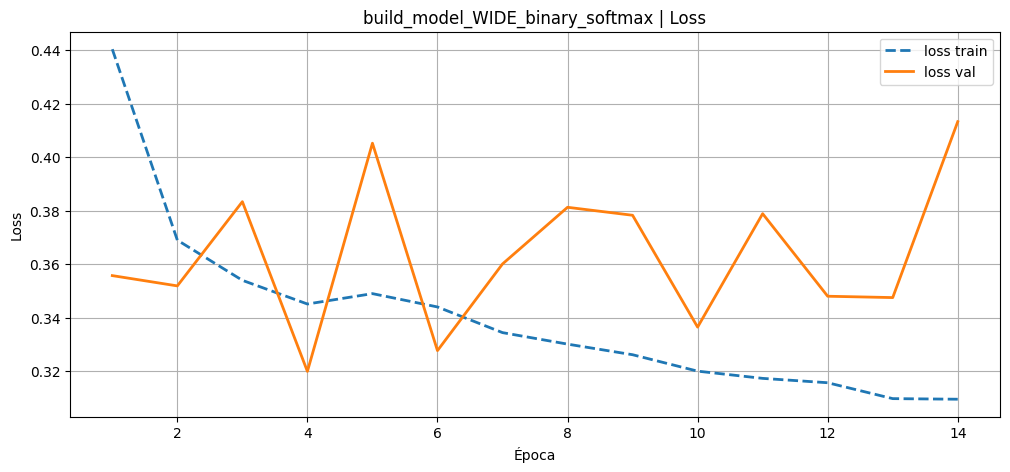

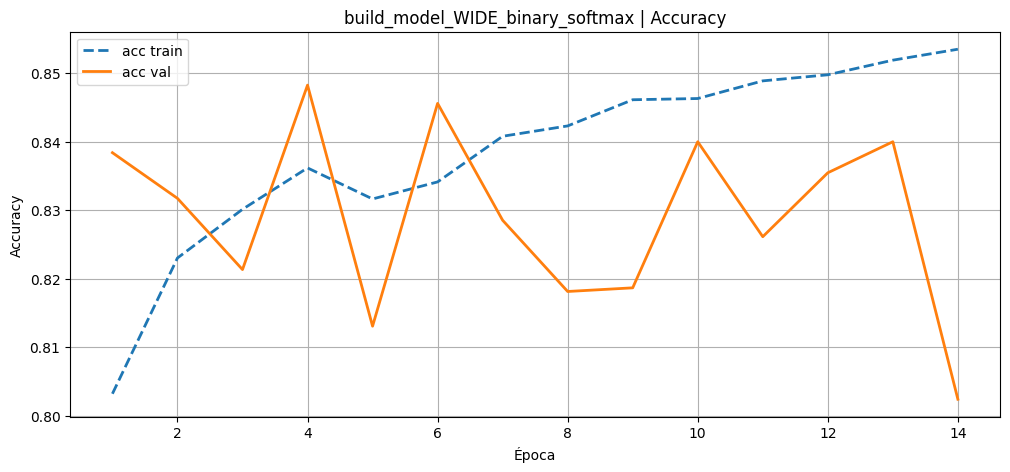

Confusion matrix (test):
[[1006  345]
 [ 394 3255]]

Classification report (test):
              precision    recall  f1-score   support

   no_passed     0.7186    0.7446    0.7314      1351
      passed     0.9042    0.8920    0.8981      3649

    accuracy                         0.8522      5000
   macro avg     0.8114    0.8183    0.8147      5000
weighted avg     0.8540    0.8522    0.8530      5000



In [105]:
modelo = build_model_WIDE_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_WIDE_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)

Epoch 1/100
44/44 [==============================] - 3s 29ms/step - loss: 0.4402 - accuracy: 0.7860 - val_loss: 0.3349 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 1s 22ms/step - loss: 0.3740 - accuracy: 0.8162 - val_loss: 0.3490 - val_accuracy: 0.8331 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 1s 22ms/step - loss: 0.3519 - accuracy: 0.8316 - val_loss: 0.3505 - val_accuracy: 0.8371 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 1s 21ms/step - loss: 0.3463 - accuracy: 0.8379 - val_loss: 0.3402 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 1s 19ms/step - loss: 0.3417 - accuracy: 0.8334 - val_loss: 0.3690 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 1s 21ms/step - loss: 0.3381 - accuracy: 0.8374 - val_loss: 0.3299 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 1s 23ms/step - lo

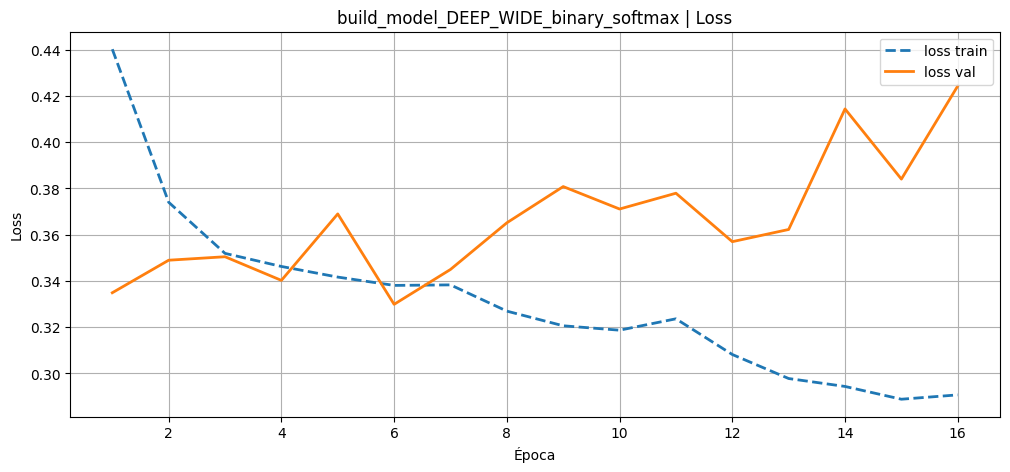

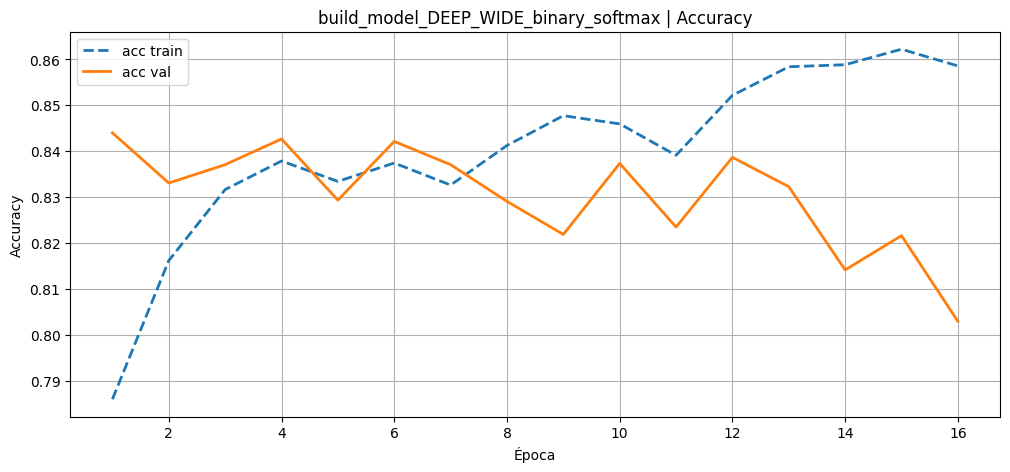

Confusion matrix (test):
[[1088  263]
 [ 531 3118]]

Classification report (test):
              precision    recall  f1-score   support

   no_passed     0.6720    0.8053    0.7327      1351
      passed     0.9222    0.8545    0.8871      3649

    accuracy                         0.8412      5000
   macro avg     0.7971    0.8299    0.8099      5000
weighted avg     0.8546    0.8412    0.8453      5000



In [106]:
modelo = build_model_DEEP_WIDE_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_DEEP_WIDE_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)

Epoch 1/100
44/44 [==============================] - 6s 91ms/step - loss: 0.4411 - accuracy: 0.7756 - val_loss: 0.3468 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 4s 89ms/step - loss: 0.3810 - accuracy: 0.8143 - val_loss: 0.3300 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 4s 87ms/step - loss: 0.3527 - accuracy: 0.8320 - val_loss: 0.3743 - val_accuracy: 0.8192 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 4s 88ms/step - loss: 0.3428 - accuracy: 0.8363 - val_loss: 0.3192 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 4s 85ms/step - loss: 0.3467 - accuracy: 0.8283 - val_loss: 0.4203 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 4s 85ms/step - loss: 0.3390 - accuracy: 0.8363 - val_loss: 0.3421 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 4s 85ms/step - lo

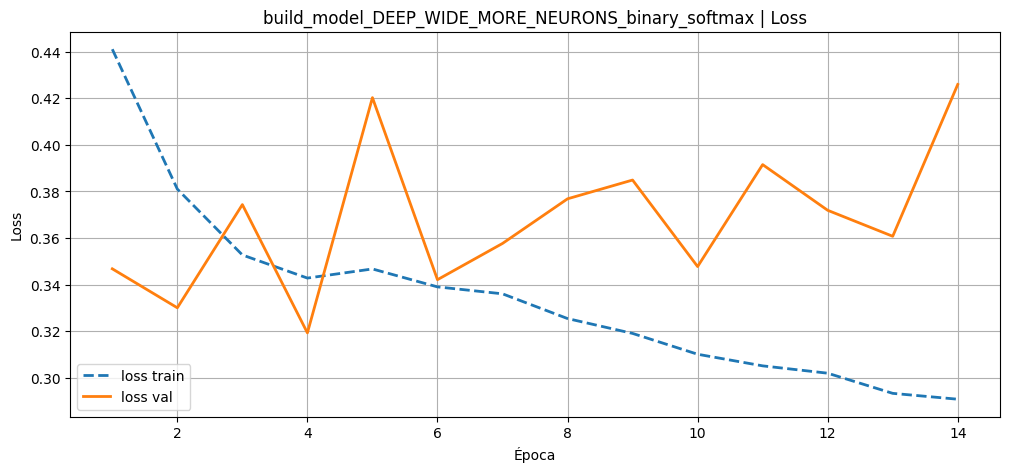

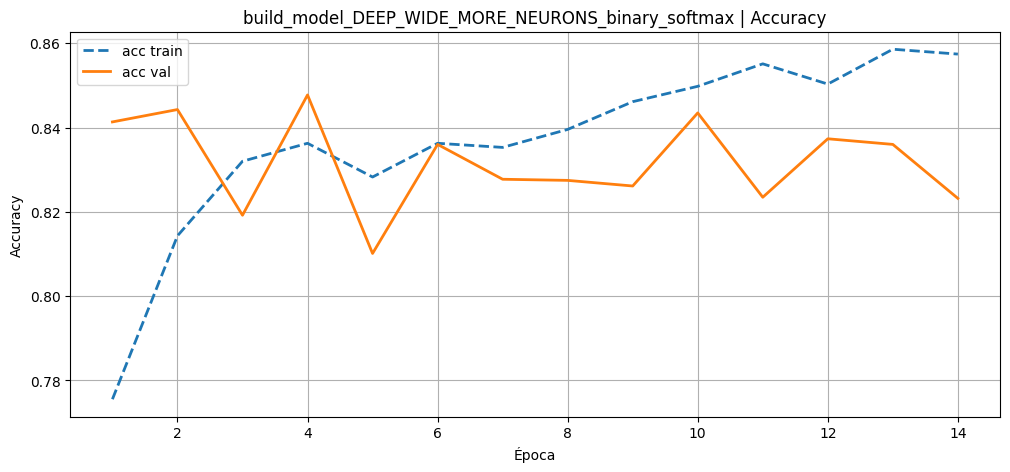

Confusion matrix (test):
[[1080  271]
 [ 487 3162]]

Classification report (test):
              precision    recall  f1-score   support

   no_passed     0.6892    0.7994    0.7402      1351
      passed     0.9211    0.8665    0.8930      3649

    accuracy                         0.8484      5000
   macro avg     0.8051    0.8330    0.8166      5000
weighted avg     0.8584    0.8484    0.8517      5000



In [107]:
modelo = build_model_DEEP_WIDE_MORE_NEURONS_binary_softmax(X_train.shape[1], num_classes=2)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[cb_early, cb_reduce],
    class_weight=class_weights,
    verbose=1
)
plot_history(history, 'build_model_DEEP_WIDE_MORE_NEURONS_binary_softmax')
evalua_clasificacion(modelo, X_test, y_test)